<a href="https://colab.research.google.com/github/esj3820/Alura-Challenge-Telecom-2-Desaf-o-Final/blob/main/ChallengeTelecomFinal_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Challenge Telecom X: Parte 2**




###El objetivo es tener un modelo predictivo capaz de ver qué clientes tienen mayor probabilidad de cancelar sus servicios.






##Bibliotecas utilizadas

In [3]:
# Bibliotecas utilizadas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
import pickle
import random
import warnings
warnings.filterwarnings('ignore')

from IPython.display import HTML, display

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                             roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay,
                             recall_score,accuracy_score, precision_score, make_scorer,f1_score)

from sklearn.model_selection import (train_test_split, GridSearchCV, StratifiedKFold, KFold,
                                     cross_validate, RandomizedSearchCV, cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as imbpipeline

from scipy import stats
from scipy.stats import t

In [4]:
# importamos catboost
!pip install catboost
from catboost import CatBoostClassifier


##Funciones

### Impresión personalizada

In [5]:
# función para impresiones con características especiales
def big_print(text, size=20, color="black"):
    print("\n")
    display(HTML(f"<span style='font-size: {size}px; color: {color};'>{text}</span>"))

### Generación datos nuevos

In [6]:
# función para generar datos de prueba nuevos con características aleatorias
# con tenure entre 0 y 6, ya que son los meses de mayor deserción
def generar_registro_cliente():
    tenure = random.randint(0, 6)
    Charges_Monthly = 65
    Charges_Total = tenure * Charges_Monthly

    return {
        'customerID': f'{random.randint(1000, 9999)}-XYZ',
        'gender': random.choice(['Male', 'Female']),
        'SeniorCitizen': random.choice([0, 1]),
        'Partner': random.choice(['Yes', 'No']),
        'Dependents': random.choice(['Yes', 'No']),
        'tenure': tenure,
        'PhoneService': random.choice(['Yes', 'No']),
        'MultipleLines': random.choice(['Yes', 'No', 'No phone service']),
        'InternetService': random.choice(['DSL', 'Fiber optic', 'No']),
        'OnlineSecurity': random.choice(['Yes', 'No', 'No internet service']),
        'OnlineBackup': random.choice(['Yes', 'No', 'No internet service']),
        'DeviceProtection': random.choice(['Yes', 'No', 'No internet service']),
        'TechSupport': random.choice(['Yes', 'No', 'No internet service']),
        'StreamingTV': random.choice(['Yes', 'No', 'No internet service']),
        'StreamingMovies': random.choice(['Yes', 'No', 'No internet service']),
        'Contract': random.choice(['Month-to-month', 'One year', 'Two year']),
        'PaperlessBilling': random.choice(['Yes', 'No']),
        'PaymentMethod': random.choice([
            'Electronic check', 'Mailed check',
            'Bank transfer (automatic)', 'Credit card (automatic)'
        ]),
        'Charges.Monthly': Charges_Monthly,
        'Charges.Total': Charges_Total
    }


### mapeo de columnas binarias

In [7]:
# función para mapear columnas Yes y No
# Transforma columnas categóricas que contienen 'Yes' a variables binarias:
#    'Yes' -> 1, todo lo demás -> 0.
#   Parámetro:
#        df (pd.DataFrame): DataFrame original.
#    Retorna:
#       pd.DataFrame: DataFrame con las columnas transformadas.
def map_yes_to_binary(df):

    df_copy = df.copy()

    for col in df_copy.columns:
        if df_copy[col].dtype == 'object':
            unique_vals = df_copy[col].dropna().unique()
            if 'Yes' in unique_vals:
                # Mapea 'Yes' a 1, todo lo demás a 0
                df_copy[col] = df_copy[col].apply(lambda x: 1 if x == 'Yes' else 0)

    return df_copy


### Despliegue de matriz de confusión

In [8]:
# función para mostrar matriz de confusión
def plot_confusion_matrix(y_test, y_previsto, modelo:str):
  # creamos la matriz de confusión
  cm = confusion_matrix(y_test, y_previsto)

  # creamos el gráfico de la matriz de confusión
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn No', 'Churn Sí'])
  disp.plot(cmap='Blues')
  plt.title(f'Matriz de Confusión {modelo}', color='firebrick', fontsize=12)

  # guadamos gráfico como archivo png
  archivo_matriz_confusion = str(f'MC_{modelo}_1.png')
  plt.savefig(archivo_matriz_confusion, dpi=300, bbox_inches='tight')
  plt.grid(False)
  plt.show()

### Despliegue de curva ROC

In [9]:
# Función para mostrar gráfico de curva ROC
def plot_roc_curve(modelo, X_test, y_test, titulo):

  # revisemos la curva AUC para este modelo
  modelo.fit(X_train, y_train)

  # Predecir probabilidades sobre conjunto de prueba
  y_scores = modelo.predict_proba(X_test)[:, 1]  # Probabilidad de clase 1

  # Calcular fpr, tpr y auc
  fpr, tpr, thresholds = roc_curve(y_test, y_scores)
  auc = roc_auc_score(y_test, y_scores)

  # configuramos display del gráfico
  plt.figure(figsize=(6, 5), facecolor='lightyellow')
  ax = plt.gca()
  ax.set_facecolor('honeydew')

  plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})', linewidth=2)
  plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
  plt.xlabel('Tasa de Falsos Positivos (FPR)')
  plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
  plt.title(f'Curva ROC - {titulo}',fontsize=14)
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.tight_layout()

  # guardamos gráfico como archivo png
# reemplazamos ' ' por '_' en titulo
  titulo = titulo.replace(' ', '_')
  archivo_roc = str(f'ROC_{titulo}.png')
  plt.savefig(archivo_roc, dpi=300, bbox_inches='tight')
  plt.show()

### Recopilación de métricas de modelos

In [10]:
# Lista para almacenar los resultados
metricas_modelos = []

# Función para calcular métricas
def calcular_metricas(modelo_nombre, y_true, y_pred):
    return {
        'Modelo': modelo_nombre,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision_Clase_1': precision_score(y_true, y_pred, pos_label=1),
        'Recall_Clase_1': recall_score(y_true, y_pred, pos_label=1),
        'F1-Score_Clase_1': f1_score(y_true, y_pred, pos_label=1)
    }

##Extracción del Archivo Normalizado del Challenge anterior



---

En el challenge anterior terminamos con un dataset normalizado, donde se habían eliminado registros con valores nulos.

Utilizaremos ese dataset para este challenge.


---



In [25]:
# leemos archivo /content/datos.csv
df = pd.read_csv('/content/datos.csv')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID_Cliente               7267 non-null   object 
 1   Churn                    7267 non-null   float64
 2   Genero_Cliente           7267 non-null   int64  
 3   Cliente_TerceraEdad      7267 non-null   int64  
 4   Cliente_Pareja           7267 non-null   int64  
 5   Cliente_Dependientes     7267 non-null   int64  
 6   Antiguedad_Meses         7267 non-null   int64  
 7   Servicio_Telefono        7267 non-null   int64  
 8   Multiples_Lineas         7267 non-null   int64  
 9   Servicio_Internet        7267 non-null   object 
 10  Seguridad_Online         7267 non-null   int64  
 11  Respaldo_Online          7267 non-null   int64  
 12  Proteccion_Dispositivo   7267 non-null   int64  
 13  Soporte_Tecnico          7267 non-null   int64  
 14  Streaming_TV            

In [27]:
df.head()

,ID_Cliente,Churn,Genero_Cliente,Cliente_TerceraEdad,Cliente_Pareja,Cliente_Dependientes,Antiguedad_Meses,Servicio_Telefono,Multiples_Lineas,Servicio_Internet,...,Proteccion_Dispositivo,Soporte_Tecnico,Streaming_TV,Streaming_Peliculas,Tipo_Contrato,Facturacion_Electronica,Metodo_Pago,Cargos_Mensuales,Cargos_Totales,Cuentas_Diarias
0,0002-ORFBO,0.0,0,0,1,1,9,1,0,DSL,...,0,1,1,0,One year,1,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,0.0,1,0,0,0,9,1,1,DSL,...,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,1.0,1,0,0,0,4,1,0,Fiber optic,...,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,1.0,1,1,1,0,13,1,0,Fiber optic,...,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,1.0,0,1,1,0,3,1,0,Fiber optic,...,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.796667


In [28]:
# imprimimos valores únicos de las columnas del df
for col in df.columns:
  print(f'{col}: {df[col].unique()}')

ID_Cliente: ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
Churn: [0. 1.]
Genero_Cliente: [0 1]
Cliente_TerceraEdad: [0 1]
Cliente_Pareja: [1 0]
Cliente_Dependientes: [1 0]
Antiguedad_Meses: [ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 11 37 49 66
 67 20 43 59 12 27  2 25 29 14 35 64 39 40  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 51 31 36 17 18 38 42
  0]
Servicio_Telefono: [1 0]
Multiples_Lineas: [0 1]
Servicio_Internet: ['DSL' 'Fiber optic' 'No']
Seguridad_Online: [0 1]
Respaldo_Online: [1 0]
Proteccion_Dispositivo: [0 1]
Soporte_Tecnico: [1 0]
Streaming_TV: [1 0]
Streaming_Peliculas: [0 1]
Tipo_Contrato: ['One year' 'Month-to-month' 'Two year']
Facturacion_Electronica: [1 0]
Metodo_Pago: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']
Cargos_Mensuales: [65.6  59.9  73.9  ... 91.75 68.8  67.85]
Cargos_Totales: [ 593.3   542.4   280.85 ...  742.9  4

##Análisis exploratorio de datos

###Verificación de la Proporción de Cancelación (Churn)

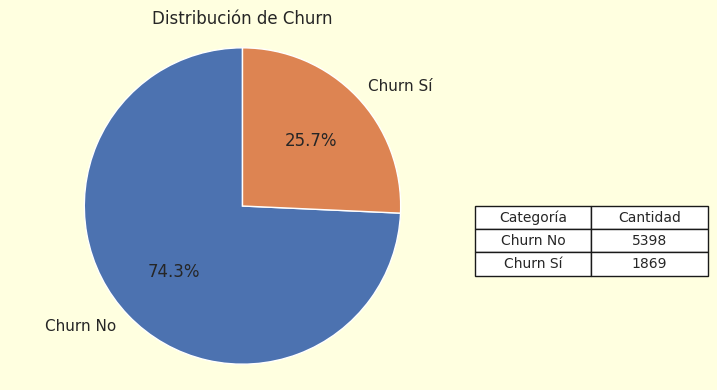

In [30]:
# Análisis de distribución de clases Churn Yes y Churn No
# creamos gráfico de torta con porcentajes y tabla con valores absolutos
sns.set(style="whitegrid")

# Contamos los valores
valores = df['Churn'].value_counts()
etiquetas = ['Churn No', 'Churn Sí']
porcentajes = valores.values

# Creamos la figura y el eje
fig, ax = plt.subplots(figsize=(6, 6))

# Personalizamos colores de fondo y área de gráfico
fig.patch.set_facecolor('lightyellow')   # Fondo de toda la figura
ax.set_facecolor('honeydew')             # Fondo del área del gráfico

# Gráfico de torta
wedges, texts, autotexts = ax.pie(
    porcentajes,
    labels=etiquetas,
    autopct='%1.1f%%',
    startangle=90
)
ax.axis('equal')  # Círculo perfecto

# Agregamos tabla con valores absolutos
tabla_data = [[etiquetas[i], porcentajes[i]] for i in range(len(etiquetas))]
col_labels = ['Categoría', 'Cantidad']

tabla = ax.table(
    cellText=tabla_data,
    colLabels=col_labels,
    cellLoc='center',
    loc='bottom',
    bbox=[1.0, 0.3, 0.5, 0.2]  # [x, y, width, height]
)

tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
plt.title('Distribución de Churn')
plt.subplots_adjust(bottom=0.3)  # Espacio para la tabla

# guardamos gráfico como imagen png
plt.savefig('graf_01_torta_churn.png', dpi=300, bbox_inches='tight')

plt.show()

###<font color=blue size=5>Distribución de Churn Yes por tenure</font>

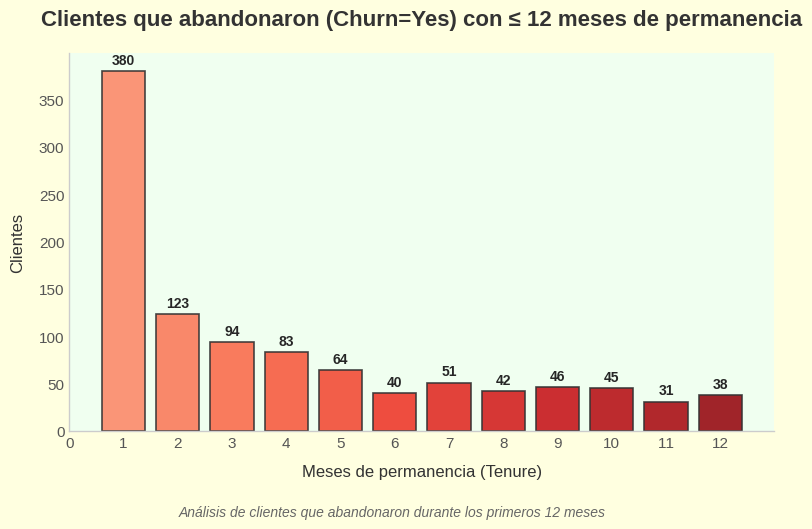

In [32]:
# Análisis de Churn por tenure
# Filtramos clientes con Churn = Yes y tenure ≤ 12
churned_short_tenure = df[(df['Churn'] == 1) & (df['Antiguedad_Meses'] <= 12)]

# Contamos clientes por tenure
tenure_counts = churned_short_tenure['Antiguedad_Meses'].value_counts().sort_index().reset_index()
tenure_counts.columns = ['Tenure', 'Clientes']

# Configuramos estilos
plt.style.use('seaborn-v0_8-whitegrid')

# Creamos figura con fondo personalizado
fig = plt.figure(figsize=(8, 5), facecolor='lightyellow')
ax = fig.add_subplot(facecolor='honeydew')  # Fondo del área del gráfico

# Colores para las barras usando un gradiente
colors = [plt.cm.Reds(i) for i in np.linspace(0.4, 0.9, len(tenure_counts))]

# Creamos gráfico de barras
bars = ax.bar(tenure_counts['Tenure'],
              tenure_counts['Clientes'],
              color=colors,
              edgecolor='#333333',
              linewidth=1.2,
              alpha=0.9)

# Añadimos etiquetas de valores
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center',
                va='bottom',
                fontsize=10,
                fontweight='bold')

# Personalización del gráfico
ax.set_title('Clientes que abandonaron (Churn=Yes) con ≤ 12 meses de permanencia',
             fontsize=16, pad=20, fontweight='bold', color='#333333')
ax.set_xlabel('Meses de permanencia (Tenure)', fontsize=12, labelpad=10, color='#333333')
ax.set_ylabel('Clientes', fontsize=12, labelpad=10, color='#333333')
ax.set_xticks(range(0, 13))
ax.tick_params(axis='both', colors='#555555')

# Decoración adicional
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#cccccc')
ax.spines['bottom'].set_color('#cccccc')

# Añadimos nota explicativa
plt.figtext(0.5, -0.05,
            'Análisis de clientes que abandonaron durante los primeros 12 meses',
            ha='center', fontsize=10, color='#666666', fontstyle='italic')
plt.grid(False)

# Ajustar layout y mostrar
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)  # Espacio para el texto inferior

# guardamos gráfico como archivo png
plt.savefig('graf_02_desercion_primer_año.png', dpi=300, bbox_inches='tight')
plt.show()

###Categorías con mayor porcentaje de Churn Yes

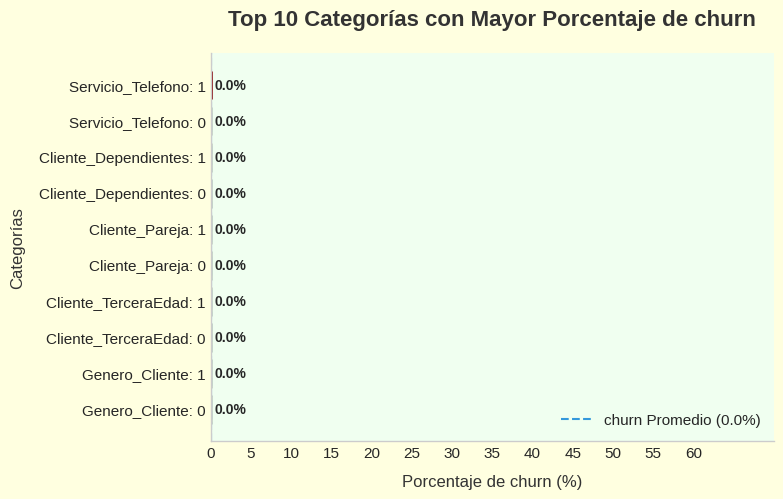

In [35]:
# Analizamos las características con mayor Churn Yes
# Convertir Churn a binario (1 para Yes, 0 para No)
df['churn_bin'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Lista de características categóricas
categorical_features = [
    'Genero_Cliente', 'Cliente_TerceraEdad', 'Cliente_Pareja', 'Cliente_Dependientes', 'Servicio_Telefono',
    'Multiples_Lineas', 'Servicio_Internet', 'Seguridad_Online', 'Respaldo_Online',
    'Proteccion_Dispositivo', 'Soporte_Tecnico', 'Streaming_TV', 'Streaming_Peliculas',
    'Tipo_Contrato', 'Facturacion_Electronica', 'Metodo_Pago'
]

# Calcular el porcentaje de churn para each categoría
results = []
for feature in categorical_features:
    # Convertir a string para incluir SeniorCitizen correctamente
    df[feature] = df[feature].astype(str)
    grouped = df.groupby(feature)['churn_bin'].mean().reset_index()
    grouped['Feature'] = feature
    # Renombrar la columna de categoría para unificar
    grouped.rename(columns={feature: 'Category'}, inplace=True)
    results.append(grouped)

# Combinar todos los resultados
results_df = pd.concat(results, ignore_index=True)
results_df.rename(columns={'churn_bin': 'churn_Percentage'}, inplace=True)

# Ordenar y seleccionar las top 10 categorías con mayor churn
top_10 = results_df.sort_values('churn_Percentage', ascending=False).head(10)

# Ordenar para mejor visualización en el gráfico
top_10 = top_10.sort_values('churn_Percentage', ascending=True)

# Crear etiquetas combinadas
top_10['Label'] = top_10['Feature'] + ': ' + top_10['Category']

# Creamos figura con fondo personalizado
fig = plt.figure(figsize=(8, 5), facecolor='lightyellow')
ax = fig.add_subplot(facecolor='honeydew')  # Fondo del área del gráfico

# Crear colores con gradiente
colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_10)))

# Gráfico de barras horizontales
bars = ax.barh(top_10['Label'],
               top_10['churn_Percentage'] * 100,
               color=colors,
               edgecolor='#333333',
               height=0.8)

# Añadir valores a las barras
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5,
             bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%',
             va='center',
             fontsize=10,
             fontweight='bold')

# Personalización
plt.title('Top 10 Categorías con Mayor Porcentaje de churn',
          fontsize=16, pad=20, fontweight='bold', color='#333333')
plt.xlabel('Porcentaje de churn (%)', fontsize=12, labelpad=10, color='#333333')
plt.ylabel('Categorías', fontsize=12, labelpad=10, color='#333333')

# AJUSTE PRINCIPAL: Limitar eje X al 60%
plt.xlim(0, 70)
plt.xticks(np.arange(0, 61, 5))

# Añadir línea vertical de referencia
avg_churn = df['churn_bin'].mean() * 100
plt.axvline(x=avg_churn,
            color='#3498db',
            linestyle='--',
            linewidth=1.5,
            label=f'churn Promedio ({avg_churn:.1f}%)')

# Destacar la barra con mayor churn
max_bar = bars[-1]
max_bar.set_edgecolor('#8b0000')
max_bar.set_linewidth(2)

# Decoración
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#cccccc')
ax.spines['bottom'].set_color('#cccccc')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(loc='lower right')

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.grid(False)

# guardamos gráfico como archivo png
plt.savefig('graf_03_top_10_churn.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# eliminamos Churn_bin
df.drop('Churn_bin', axis=1, inplace=True)

# 🚧Preparación de datos

##Eliminación de Columnas Irrelevantes

In [37]:
# eliminamos columna ID_Clientes
df.drop('ID_Cliente', axis=1, inplace=True)
df.head(5)

,Churn,Genero_Cliente,Cliente_TerceraEdad,Cliente_Pareja,Cliente_Dependientes,Antiguedad_Meses,Servicio_Telefono,Multiples_Lineas,Servicio_Internet,Seguridad_Online,...,Soporte_Tecnico,Streaming_TV,Streaming_Peliculas,Tipo_Contrato,Facturacion_Electronica,Metodo_Pago,Cargos_Mensuales,Cargos_Totales,Cuentas_Diarias,churn_bin
0,0.0,0,0,1,1,9,1,0,DSL,0,...,1,1,0,One year,1,Mailed check,65.6,593.30,2.186667,0
1,0.0,1,0,0,0,9,1,1,DSL,0,...,0,0,1,Month-to-month,0,Mailed check,59.9,542.40,1.996667,0
2,1.0,1,0,0,0,4,1,0,Fiber optic,0,...,0,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.463333,0
3,1.0,1,1,1,0,13,1,0,Fiber optic,0,...,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.266667,0
4,1.0,0,1,1,0,3,1,0,Fiber optic,0,...,1,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.796667,0


##Encoding


<font size=4>

*   Para la codificación reemplazaremos los Yes por 1 y los No por 0.

*   Para las columnas categóricas restantes utilizaremos OneHotEncoder
</font>





In [38]:
# mapeamos los Yes a 1, No y No+cualquier_cosa a 0
df = map_yes_to_binary(df)

In [39]:
df.head()

,Churn,Genero_Cliente,Cliente_TerceraEdad,Cliente_Pareja,Cliente_Dependientes,Antiguedad_Meses,Servicio_Telefono,Multiples_Lineas,Servicio_Internet,Seguridad_Online,...,Soporte_Tecnico,Streaming_TV,Streaming_Peliculas,Tipo_Contrato,Facturacion_Electronica,Metodo_Pago,Cargos_Mensuales,Cargos_Totales,Cuentas_Diarias,churn_bin
0,0.0,0,0,1,1,9,1,0,DSL,0,...,1,1,0,One year,1,Mailed check,65.6,593.30,2.186667,0
1,0.0,1,0,0,0,9,1,1,DSL,0,...,0,0,1,Month-to-month,0,Mailed check,59.9,542.40,1.996667,0
2,1.0,1,0,0,0,4,1,0,Fiber optic,0,...,0,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.463333,0
3,1.0,1,1,1,0,13,1,0,Fiber optic,0,...,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.266667,0
4,1.0,0,1,1,0,3,1,0,Fiber optic,0,...,1,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.796667,0


In [41]:
# Separamos características (X) y variable objetivo (y)
X = df.drop(columns=['Churn'])
y = df['Churn']

In [44]:
# Identificamos columnas categóricas restantes a codificar
categorical_cols = ['Genero_Cliente', 'Servicio_Internet', 'Tipo_Contrato', 'Metodo_Pago']

# Configuramos el transformador
preprocessor = ColumnTransformer(transformers=[
                                ('cat',
                                 OneHotEncoder(drop='first', sparse_output=False),
                                 categorical_cols)],
                                  remainder='passthrough')

In [45]:
# Aplicamos el encoded a las características
X_encoded = preprocessor.fit_transform(X)

In [46]:
# Convertimos a DataFrame con nombres de columnas
# Obtenemos nombres de características después del encoding
feature_names = preprocessor.get_feature_names_out()
X_encoded_df = pd.DataFrame(X_encoded, columns=feature_names)
X_encoded_df.head()

,cat__Genero_Cliente_1,cat__Servicio_Internet_Fiber optic,cat__Servicio_Internet_No,cat__Tipo_Contrato_One year,cat__Tipo_Contrato_Two year,cat__Metodo_Pago_Credit card (automatic),cat__Metodo_Pago_Electronic check,cat__Metodo_Pago_Mailed check,remainder__Cliente_TerceraEdad,remainder__Cliente_Pareja,...,remainder__Respaldo_Online,remainder__Proteccion_Dispositivo,remainder__Soporte_Tecnico,remainder__Streaming_TV,remainder__Streaming_Peliculas,remainder__Facturacion_Electronica,remainder__Cargos_Mensuales,remainder__Cargos_Totales,remainder__Cuentas_Diarias,remainder__churn_bin
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,...,1,0,1,1,0,1,65.6,593.3,2.186667,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,...,0,0,0,0,1,0,59.9,542.4,1.996667,0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,...,0,1,0,0,0,1,73.9,280.85,2.463333,0
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,...,1,1,0,1,1,1,98.0,1237.85,3.266667,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,...,0,0,1,1,0,1,83.9,267.4,2.796667,0


In [47]:
# generamos dataframe completo con X_encoded_df + y
df_codificado = pd.concat([X_encoded_df, y], axis=1)
df_codificado.head()

,cat__Genero_Cliente_1,cat__Servicio_Internet_Fiber optic,cat__Servicio_Internet_No,cat__Tipo_Contrato_One year,cat__Tipo_Contrato_Two year,cat__Metodo_Pago_Credit card (automatic),cat__Metodo_Pago_Electronic check,cat__Metodo_Pago_Mailed check,remainder__Cliente_TerceraEdad,remainder__Cliente_Pareja,...,remainder__Proteccion_Dispositivo,remainder__Soporte_Tecnico,remainder__Streaming_TV,remainder__Streaming_Peliculas,remainder__Facturacion_Electronica,remainder__Cargos_Mensuales,remainder__Cargos_Totales,remainder__Cuentas_Diarias,remainder__churn_bin,Churn
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,...,0,1,1,0,1,65.6,593.3,2.186667,0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,...,0,0,0,1,0,59.9,542.4,1.996667,0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,...,1,0,0,0,1,73.9,280.85,2.463333,0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,...,1,0,1,1,1,98.0,1237.85,3.266667,0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,...,0,1,1,0,1,83.9,267.4,2.796667,0,1.0


In [49]:
# eliminamos remainder__Charges.Monthly
df_codificado.drop('remainder__Cargos_Mensuales', axis=1, inplace=True)
df_codificado.head()

,cat__Genero_Cliente_1,cat__Servicio_Internet_Fiber optic,cat__Servicio_Internet_No,cat__Tipo_Contrato_One year,cat__Tipo_Contrato_Two year,cat__Metodo_Pago_Credit card (automatic),cat__Metodo_Pago_Electronic check,cat__Metodo_Pago_Mailed check,remainder__Cliente_TerceraEdad,remainder__Cliente_Pareja,...,remainder__Respaldo_Online,remainder__Proteccion_Dispositivo,remainder__Soporte_Tecnico,remainder__Streaming_TV,remainder__Streaming_Peliculas,remainder__Facturacion_Electronica,remainder__Cargos_Totales,remainder__Cuentas_Diarias,remainder__churn_bin,Churn
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,...,1,0,1,1,0,1,593.3,2.186667,0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,...,0,0,0,0,1,0,542.4,1.996667,0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,...,0,1,0,0,0,1,280.85,2.463333,0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,...,1,1,0,1,1,1,1237.85,3.266667,0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,...,0,0,1,1,0,1,267.4,2.796667,0,1.0


In [50]:
# guardamos dataframe df_codificado como archivo csv
df_codificado.to_csv('df_codificado.csv', index=False)

##Análisis de correlación de variables

,Correlación
cat__Servicio_Internet_Fiber optic,0.300949
cat__Metodo_Pago_Electronic check,0.294626
remainder__Cuentas_Diarias,0.189866
remainder__Facturacion_Electronica,0.186666
remainder__Soporte_Tecnico,-0.160440
remainder__Cliente_Dependientes,-0.161384
remainder__Seguridad_Online,-0.166828
cat__Tipo_Contrato_One year,-0.173958
remainder__Cargos_Totales,-0.193345
cat__Servicio_Internet_No,-0.224051


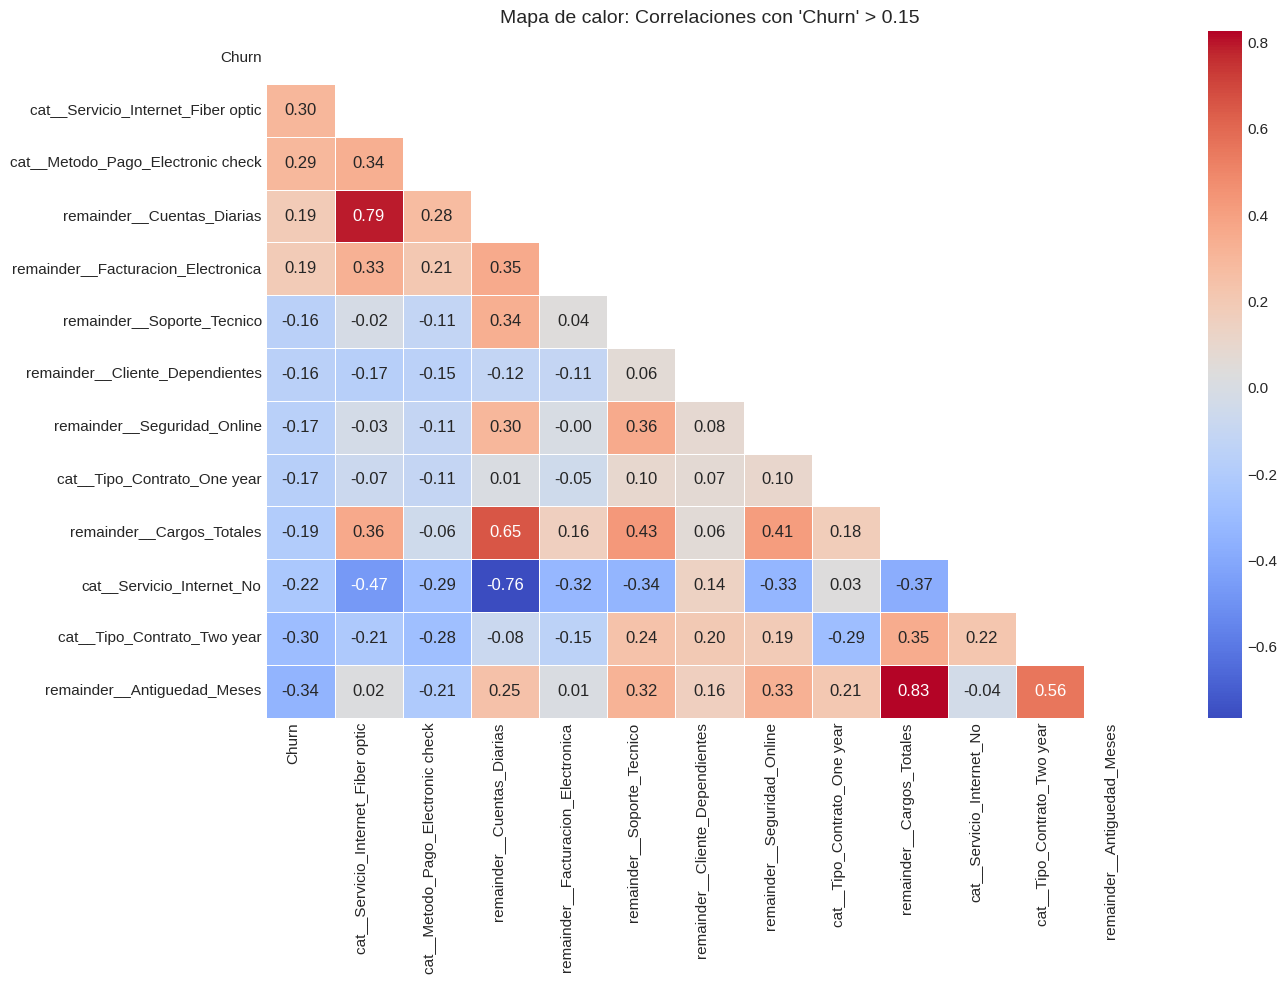

In [51]:
# Analizamos la correlación de las variables con Churn, filtrando un umbral de correlación en 15%
df = pd.read_csv('/content/df_codificado.csv')
umbral = 0.15

# Matriz de correlación
corr_matrix = df.corr()

# Obtenemos correlaciones con 'Churn'
correlaciones_churn = corr_matrix['Churn'].drop('Churn')

# Filtramos por umbral
correlaciones_filtradas = correlaciones_churn[abs(correlaciones_churn) > umbral].sort_values(ascending=False)

# Mostramos tabla de correlaciones ordenada
big_print(f"Correlaciones con 'Churn' mayores a {umbral}%",20,'brown')
display(correlaciones_filtradas.to_frame(name='Correlación'))

# Creamos submatriz para heatmap
variables = ['Churn'] + list(correlaciones_filtradas.index)
filtered_corr_matrix = corr_matrix.loc[variables, variables]

# Creamos máscara inferior
mask = np.triu(np.ones_like(filtered_corr_matrix, dtype=bool))

# Plot del heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(filtered_corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f"Mapa de calor: Correlaciones con 'Churn' > {umbral}",fontsize=14)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.grid(False)

# guardamos mapa de calor como archivo png
plt.savefig('mapa_de_calor_correlacion_churn.png', dpi=300, bbox_inches='tight')
plt.show()

##Análisis de multicolinealidad

# Modelos probados

##DecisionTreeClassifier sin optimizaci0nes

              precision    recall  f1-score   support

         0.0       0.83      0.86      0.85      1080
         1.0       0.55      0.49      0.52       374

    accuracy                           0.77      1454
   macro avg       0.69      0.68      0.68      1454
weighted avg       0.76      0.77      0.76      1454



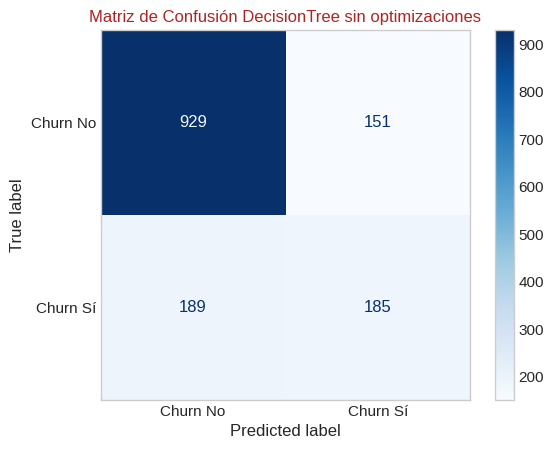

In [52]:
# Separamos variables dependiente e independientes
# leemos archivo guardado
df = pd.read_csv('df_codificado.csv')

X = df.drop('Churn', axis=1)
y = df['Churn']

# Separamos Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# creamos modelo DecisionTreeClasifier
modelo = DecisionTreeClassifier(random_state=42,max_depth=10)

# entrenamos con conjunto de train
modelo.fit(X_train, y_train)
# revisemos las métricas y la matriz de confusión

y_previsto = modelo.predict(X_test)

big_print("Reporte de Clasificación DecisionTree sin optimizaciones:", 20,'brown')
print(classification_report(y_test, y_previsto))

# mostramos matriz de confusión
plot_confusion_matrix(y_test, y_previsto, 'DecisionTree sin optimizaciones')


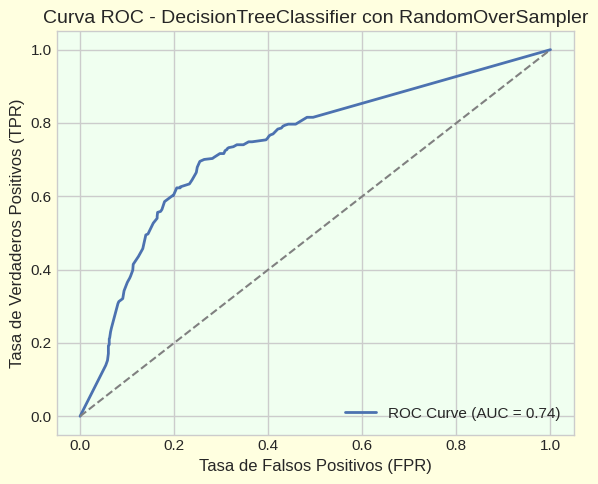

In [53]:
# mostramos curva ROC
plot_roc_curve(modelo, X_test, y_test, 'DecisionTreeClassifier con RandomOverSampler')

##DecisionTreeClassifier con Validación cruzada

Accuracy  : 0.766 ± 0.012
Precision : 0.555 ± 0.035
Recall    : 0.481 ± 0.044
F1        : 0.513 ± 0.025




              precision    recall  f1-score   support

         0.0       0.83      0.86      0.85      1080
         1.0       0.55      0.49      0.52       374

    accuracy                           0.77      1454
   macro avg       0.69      0.68      0.68      1454
weighted avg       0.76      0.77      0.76      1454



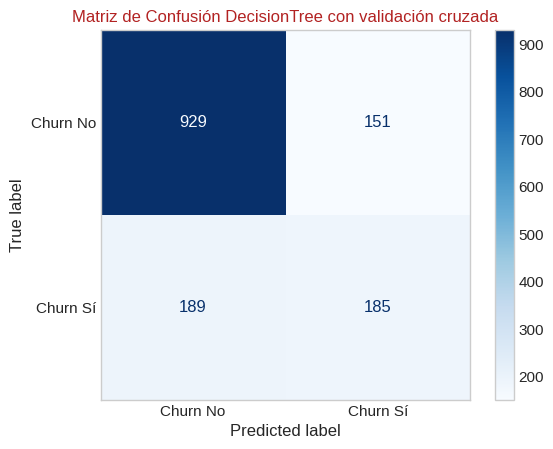

In [54]:
# Separamos variables predictoras (X) y variable objetivo (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Separamos en conjunto de entrenamiento y prueba (stratify mantiene proporción de clases)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Creamos modelo
modelo = DecisionTreeClassifier(random_state=42, max_depth=10)

# Validación cruzada sobre el conjunto de entrenamiento
scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_resultados = cross_validate(
    modelo, X_train, y_train, cv=5, scoring=scoring, return_train_score=False
)

# Mostramos resultados promedios de la validación cruzada
big_print("Validación cruzada (solo en TRAIN)",20,'brown')
for metrica in scoring:
    puntajes = cv_resultados[f'test_{metrica}']
    print(f"{metrica.capitalize():<10}: {puntajes.mean():.3f} ± {puntajes.std():.3f}")

# Entrenamos el modelo final con todos los datos de entrenamiento
modelo.fit(X_train, y_train)

# Predecimos con datos de test (jamás vistos por el modelo)
y_pred = modelo.predict(X_test)

# Reporte de clasificación
big_print("Reporte de Clasificación DecisionTree con CrossValidation", 20,'firebrick')
print(classification_report(y_test, y_pred))

# mostramos matriz de confusión
plot_confusion_matrix(y_test, y_pred, 'DecisionTree con validación cruzada')

##DecisionTreeClassifier con balanceo de clases

              precision    recall  f1-score   support

         0.0       0.88      0.70      0.78      1080
         1.0       0.46      0.72      0.56       374

    accuracy                           0.71      1454
   macro avg       0.67      0.71      0.67      1454
weighted avg       0.77      0.71      0.72      1454



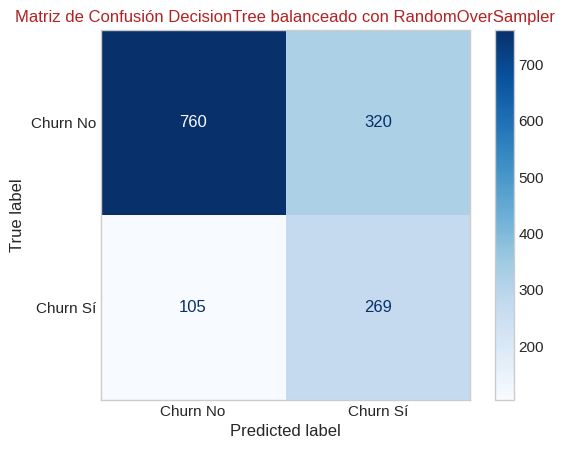

              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84      1080
         1.0       0.54      0.58      0.56       374

    accuracy                           0.77      1454
   macro avg       0.70      0.71      0.70      1454
weighted avg       0.77      0.77      0.77      1454



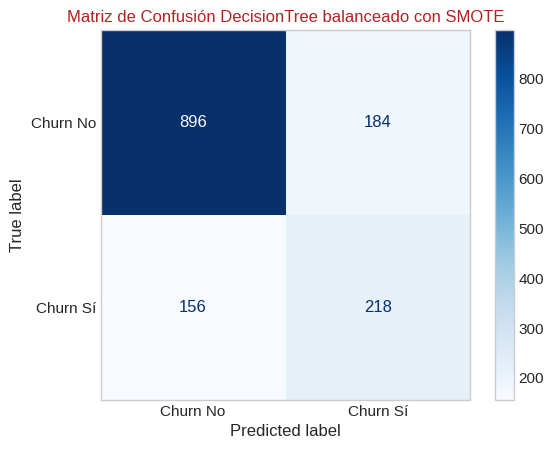

              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83      1080
         1.0       0.52      0.59      0.55       374

    accuracy                           0.76      1454
   macro avg       0.69      0.70      0.69      1454
weighted avg       0.77      0.76      0.76      1454



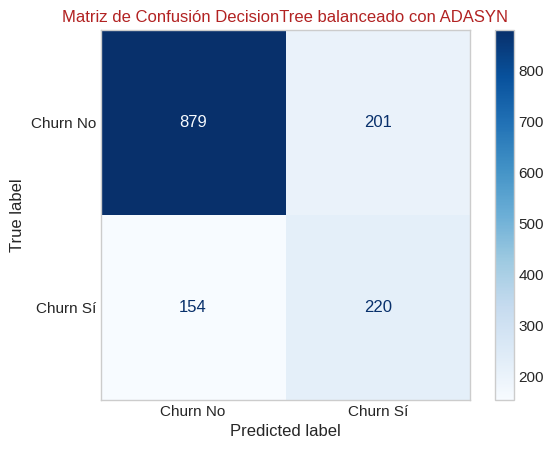

              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84      1080
         1.0       0.54      0.59      0.56       374

    accuracy                           0.77      1454
   macro avg       0.70      0.71      0.70      1454
weighted avg       0.77      0.77      0.77      1454



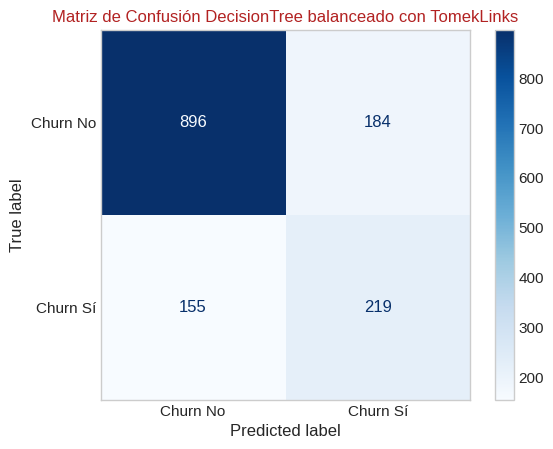

             Técnica  Accuracy  Precision    Recall  F1-score
0  RandomOverSampler  0.707703   0.456706  0.719251  0.558671
2             ADASYN  0.755846   0.522565  0.588235  0.553459
3         TomekLinks  0.766850   0.543424  0.585561  0.563707
1              SMOTE  0.766162   0.542289  0.582888  0.561856


In [55]:
# Cargamos datos
df = pd.read_csv("df_codificado.csv")

# Separamos variables
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Separamos en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Diccionario con técnicas de muestreo
samplers = {
    "RandomOverSampler": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "TomekLinks": TomekLinks()
}

# Almacenar resultados
resultados = []

# Entrenamiento y evaluación por técnica
def entrenar_y_evaluar(X_res, y_res, nombre):
    modelo = DecisionTreeClassifier(max_depth=10, random_state=42)
    modelo.fit(X_res, y_res)
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    resultados.append({
        "Técnica": nombre,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    })

    big_print(f"===== {nombre} =====",20,'brown')
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn No', 'Churn Sí'])
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión DecisionTree balanceado con {nombre}", color='firebrick', fontsize=12)
    plt.grid(False)
    # guardamos gráfico como archivo png
    plt.savefig(f'MC_DecisionTree_{nombre}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Ejecutar para cada técnica
for nombre, sampler in samplers.items():
    try:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
        entrenar_y_evaluar(X_res, y_res, nombre)
    except Exception as e:
        print(f"Error en {nombre}: {e}")

# Mostrar tabla comparativa
df_resultados = pd.DataFrame(resultados)
big_print("📊 Métricas DecisionTree por Técnica de Balanceo:",20,'brown')
print(df_resultados.sort_values("Recall", ascending=False))


<font color=red size=5>Graficamos Recall y F1 para las cuatro técnicas de balanceo</font>

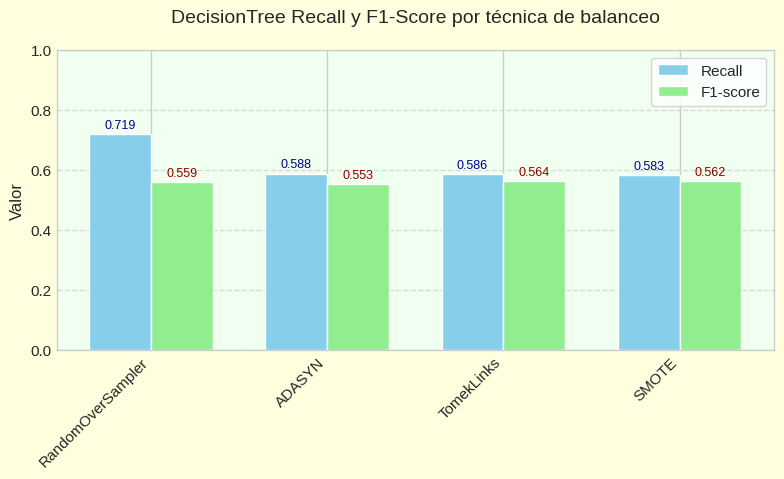

In [56]:
# Ordenar el DataFrame por Recall de mayor a menor
df_sorted = df_resultados.sort_values('Recall', ascending=False)

# Configuración del gráfico
plt.figure(figsize=(8, 4), facecolor='lightyellow')
ax = plt.gca()
ax.set_facecolor('honeydew')

# Configuración de barras
n = len(df_sorted)
bar_width = 0.35
index = np.arange(n)

# Creamos barras para Recall y F1-score
plt.bar(index - bar_width/2, df_sorted['Recall'], bar_width,
        color='skyblue', label='Recall')
plt.bar(index + bar_width/2, df_sorted['F1-score'], bar_width,
        color='lightgreen', label='F1-score')

# Añadimos valores en las barras
for i, (rec, f1) in enumerate(zip(df_sorted['Recall'], df_sorted['F1-score'])):
    plt.text(i - bar_width/2, rec + 0.02, f"{rec:.3f}",
             ha='center', fontsize=9, color='darkblue')
    plt.text(i + bar_width/2, f1 + 0.02, f"{f1:.3f}",
             ha='center', fontsize=9, color='darkred')

# Personalización del gráfico
plt.title('DecisionTree Recall y F1-Score por técnica de balanceo', pad=20, fontsize=14)
plt.ylabel('Valor')
plt.ylim(0, 1)
plt.xticks(index, df_sorted['Técnica'], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(frameon=True, loc='best')

# Mejoramos espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.15)

# guardamos gráfico como archivo png
plt.savefig('graf_DTC_recall_por_tecnica_balaceo.png', dpi=300, bbox_inches='tight')
plt.show()

<font color=red size=4>El mejor modelo DecisionTree se obtuvo con RandomOverSampler</font>

<font color=red size=5>Intervalo de confianza del Recall para DecisionTree con RandomOverSamper</font>

In [57]:
# revisemos el intervalo de confianza para el modelo balanceado con RandomOverSampler
# Cargamos el dataset
df = pd.read_csv('df_codificado.csv')

# Separamos variables predictoras y objetivo
X = df.drop('Churn', axis=1)
y = df['Churn']

# Creamos pipeline con RandomOverSampler + modelo
pipeline = imbpipeline([
    ('oversample', RandomOverSampler(random_state=42)),
    ('modelo', DecisionTreeClassifier(random_state=42, max_depth=10))
])

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Métrica que queremos evaluar 'recall'
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='recall')

# Calculamos media y desviación estándar
mean_score = np.mean(scores)
std_score = np.std(scores)

# Calculamos intervalo de confianza 95%
confidence = 0.95
z = stats.norm.ppf(1 - (1 - confidence)/2)
margin_error = z * std_score / np.sqrt(len(scores))
lower = mean_score - margin_error
upper = mean_score + margin_error

# Mostramos resultados
big_print(f"Recall promedio: {mean_score:.4f}",20,'red')
big_print(f"Intervalo de confianza del 95%: ({lower:.4f}, {upper:.4f})",20,'red')


<font color=red size=5>Curva ROC para DecisionTreeClassifier</font>

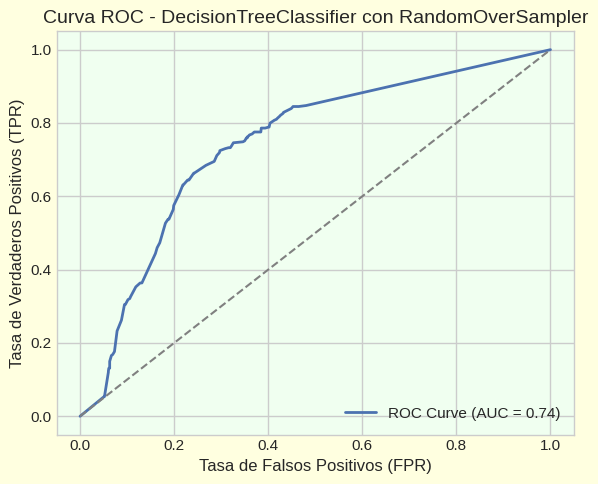

In [58]:
# mostramos curva ROC de pipeline
plot_roc_curve(pipeline, X_test, y_test, 'DecisionTreeClassifier con RandomOverSampler')

##DecisionTreeClassifier optimización de parámetros

In [59]:
# Cargamos datos
df = pd.read_csv("df_codificado.csv")
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Definimos pipeline con oversampling
pipeline_dt = imbpipeline(steps=[
    ("oversample", RandomOverSampler(random_state=42)),
    ("model", DecisionTreeClassifier(random_state=42))
])

# Definimos grilla de hiperparámetros
param_grid = {
    "model__max_depth": [None, 5, 10, 15, 20],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__criterion": ["gini", "entropy"]
}

# Scorer personalizado para recall de clase 1
recall_class1_scorer = make_scorer(recall_score, pos_label=1)

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(
    pipeline_dt,
    param_grid,
    scoring=recall_class1_scorer,  # optimiza recall de clase 1
    n_jobs=-1,
    cv=3
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('oversample',
                                        RandomOverSampler(random_state=42)),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 5, 10, 15, 20],
                         'model__min_samples_leaf': [1, 2, 4, 8],
                         'model__min_samples_split': [2, 5, 10, 20]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=1))

model__criterion: 	gini
model__max_depth: 	5
model__min_samples_leaf: 	1
model__min_samples_split: 	2




              precision    recall  f1-score   support

         0.0       0.90      0.69      0.78      1620
         1.0       0.47      0.79      0.59       561

    accuracy                           0.72      2181
   macro avg       0.69      0.74      0.69      2181
weighted avg       0.79      0.72      0.73      2181



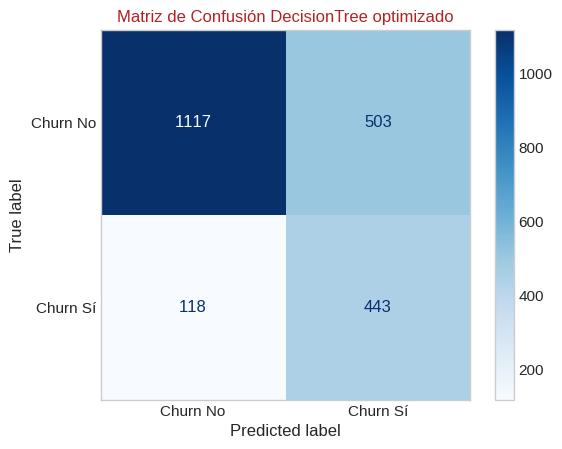

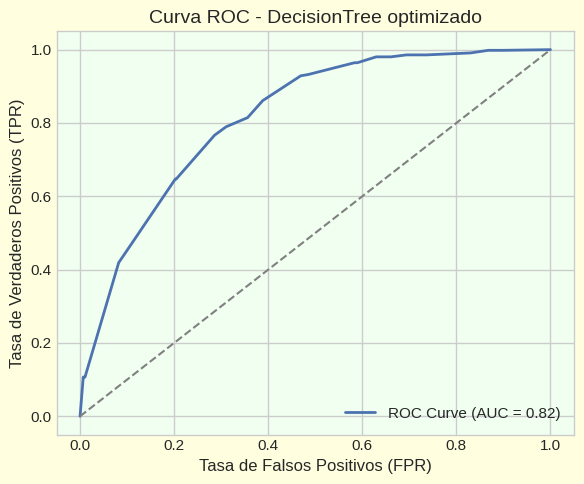

In [60]:
# imprimimos mejores parámetros
big_print("Mejores parámetros encontrados DecisionTree:",20,'brown')
for param, value in grid_search.best_params_.items():
    print(f"{param}: \t{value}")

# Evaluamos en test
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

# guardamos métricas del modelo para informe fina
metricas_modelos.append(calcular_metricas('DecisionTree', y_test, y_pred))

# imprimimos reporte de clasificación
big_print("\nReporte de clasificación:",20,'brown')
print(classification_report(y_test, y_pred))

# mostramos matriz de confusión
plot_confusion_matrix(y_test, y_pred, 'DecisionTree optimizado')

# mostramos curva ROC
plot_roc_curve(best_pipeline, X_test, y_test, 'DecisionTree optimizado')

##Pipeline DecisionTreeClassifier optimizado

In [61]:
# Definimos pipeline con los parámetros calculados previamente
pipeline_dt = grid_search.best_estimator_

# Entrenamos pipeline
pipeline_dt.fit(X_train, y_train)

# guardamos el pipeline optimizado
ruta_modelo = "pipeline_dt_optimizado.pkl"
joblib.dump(pipeline_dt, ruta_modelo)
big_print(f"Pipeline guardado en {ruta_modelo}",20)

# cargar el pipeline optimizado
pipeline_cargado = joblib.load(ruta_modelo)
big_print("Pipeline cargado correctamente.",20)

# ejecutamos el pipeline cargado en test
y_pred_cargado = pipeline_cargado.predict(X_test)

big_print("Reporte de clasificación usando el pipeline cargado:",20,'brown')
print(classification_report(y_test, y_pred_cargado))

              precision    recall  f1-score   support

         0.0       0.90      0.69      0.78      1620
         1.0       0.47      0.79      0.59       561

    accuracy                           0.72      2181
   macro avg       0.69      0.74      0.69      2181
weighted avg       0.79      0.72      0.73      2181



##CatBoost

##CatBoost sin optimizaciones

              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      1080
         1.0       0.59      0.47      0.52       374

    accuracy                           0.78      1454
   macro avg       0.71      0.68      0.69      1454
weighted avg       0.77      0.78      0.77      1454



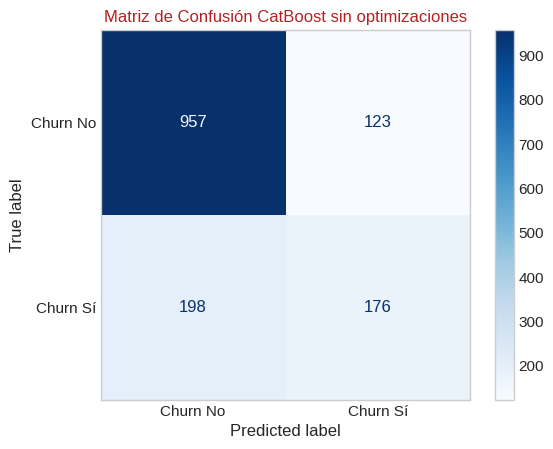

In [62]:
# Cargamos el dataset
df = pd.read_csv('df_codificado.csv')

# Separación de variables dependiente e independientes
X = df.drop('Churn', axis=1)
y = df['Churn']

# Separación en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# creamos modelo CatBoost
modelo = CatBoostClassifier(random_state=42,max_depth=10, verbose=0)

# entrenamos con conjunto de train
modelo.fit(X_train, y_train, verbose=False)

# revisemos las métricas y la matriz de confusión
y_previsto = modelo.predict(X_test)

big_print("Reporte de Clasificación CatBoost sin optimizaciones", 20,'firebrick')
print(classification_report(y_test, y_previsto))

# mostramos matriz de confusión
plot_confusion_matrix(y_test, y_previsto, 'CatBoost sin optimizaciones')

###CatBosst con Validación cruzada

Accuracy  : 0.788 ± 0.013
Precision : 0.614 ± 0.030
Recall    : 0.473 ± 0.038
F1        : 0.534 ± 0.034




              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      1080
         1.0       0.59      0.47      0.52       374

    accuracy                           0.78      1454
   macro avg       0.71      0.68      0.69      1454
weighted avg       0.77      0.78      0.77      1454



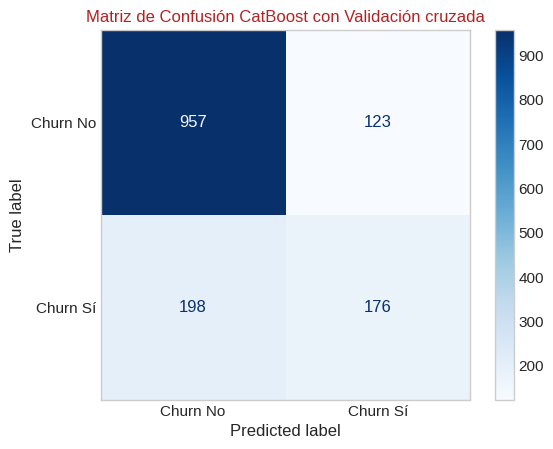

In [63]:
# Cargamos el dataset
df = pd.read_csv('df_codificado.csv')

# Separamos variables predictoras (X) y variable objetivo (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Separamos en conjunto de entrenamiento y prueba (stratify mantiene proporción de clases)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

# creamos modelo CatBoost
modelo = CatBoostClassifier(random_state=42,max_depth=10, verbose=0)

# Validación cruzada sobre el conjunto de entrenamiento
scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_resultados = cross_validate(modelo, X_train, y_train, cv=5,
                               scoring=scoring, return_train_score=False)

# Mostramos resultados promedios de la validación cruzada
big_print("CatBoost con Validación cruzada",20,'brown')
for metrica in scoring:
    puntajes = cv_resultados[f'test_{metrica}']
    print(f"{metrica.capitalize():<10}: {puntajes.mean():.3f} ± {puntajes.std():.3f}")

# Entrenamos el modelo final con todos los datos de entrenamiento
modelo.fit(X_train, y_train, verbose=False)

# Predecimos con datos de test (jamás vistos por el modelo)
y_pred = modelo.predict(X_test)

# Reporte de clasificación
big_print("Reporte de Clasificación CatBoost con Validación Cruzada", 20,'firebrick')
print(classification_report(y_test, y_pred))

# mostramos matriz de confusión
plot_confusion_matrix(y_test, y_pred, 'CatBoost con Validación cruzada')

##CatBosst con balanceo de clases



---


<font color=red size=4>Balanceo con auto_class_weights='Balanced'</font>

              precision    recall  f1-score   support

         0.0       0.86      0.81      0.84      1080
         1.0       0.53      0.63      0.58       374

    accuracy                           0.76      1454
   macro avg       0.70      0.72      0.71      1454
weighted avg       0.78      0.76      0.77      1454



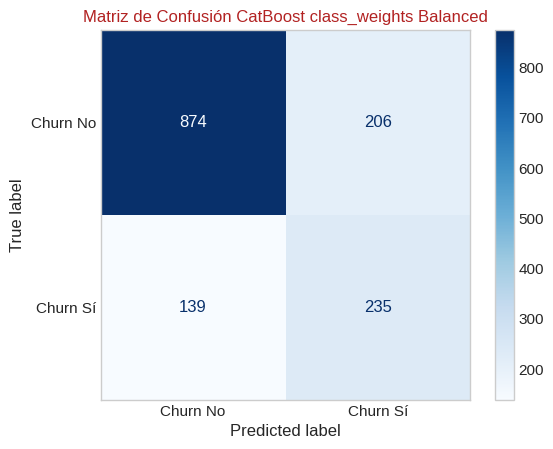

In [64]:
# Cargamos el dataset
df = pd.read_csv('df_codificado.csv')

# Separación de variables dependiente e independientes
X = df.drop('Churn', axis=1)
y = df['Churn']

# Separación en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# creamos modelo CatBoost con balanceo de clases
modelo = CatBoostClassifier(random_state=42,max_depth=10,
                          auto_class_weights='Balanced',
                          verbose=0)

# entrenamos con conjunto de train
modelo.fit(X_train, y_train, verbose=False)

# revisemos las métricas y la matriz de confusión
y_previsto = modelo.predict(X_test)

big_print("Reporte de Clasificación CatBoost class_weights Balanced", 20,'firebrick')
print(classification_report(y_test, y_previsto))

# mostramos matriz de confusión
plot_confusion_matrix(y_test, y_previsto, 'CatBoost class_weights Balanced')



---


<font color=red size=4>Balanceo con weight_ratio = n_class0 / n_class1</font>

              precision    recall  f1-score   support

         0.0       0.93      0.61      0.74      1080
         1.0       0.44      0.86      0.58       374

    accuracy                           0.68      1454
   macro avg       0.68      0.74      0.66      1454
weighted avg       0.80      0.68      0.70      1454



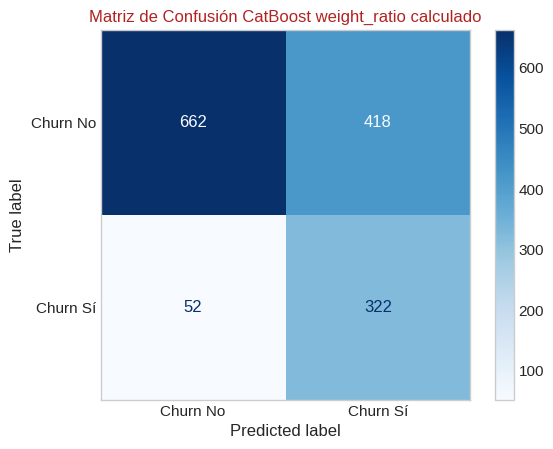

In [65]:
# Cargamos el dataset
df = pd.read_csv('df_codificado.csv')

# Separación de variables dependiente e independientes
X = df.drop('Churn', axis=1)
y = df['Churn']

# Separación en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# creamos modelo CatBoost con balanceo de clases definido según ratio de clases
# Calculamos ratio exacto
n_class0 = sum(y_train == 0)
n_class1 = sum(y_train == 1)
weight_ratio = n_class0 / n_class1

modelo = CatBoostClassifier(
    class_weights=[1, weight_ratio],
    iterations=1000,
    early_stopping_rounds=50,
    eval_metric='Recall',
    random_state=42,
    verbose=0
)

modelo.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    use_best_model=True,
    verbose=False
)

# revisemos las métricas y la matriz de confusión
y_previsto = modelo.predict(X_test)

big_print("Reporte de Clasificación CatBoost weight_ratio calculado", 20,'firebrick')
print(classification_report(y_test, y_previsto))

# mostramos matriz de confusión
plot_confusion_matrix(y_test, y_previsto, 'CatBoost weight_ratio calculado')

<font color=red size=4>El balanceo utilizando weight_ratio = n_class0 / n_class1 tiene resultados mucho mejores que utilizando auto_class_weights='Balanced'</font>


---



##CatBoost optimización de parámetros





---


<font color=red size=4>Búsqueda Aleatoria (RandomizedSearchCV)</font>

In [66]:
param_dist = {
    'depth': np.arange(4, 11),
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15],
    'l2_leaf_reg': np.logspace(-2, 2, 10),
    'border_count': [32, 64, 128, 256],
    'min_data_in_leaf': [1, 5, 10, 20],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
}

modelo = CatBoostClassifier(
    class_weights=[1, weight_ratio],
    iterations=1000,
    early_stopping_rounds=50,
    random_state=42,
    verbose=0
)

search = RandomizedSearchCV(
    modelo,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train, eval_set=[(X_test, y_test)])

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7a76f3e36890>,
                   n_iter=50, n_jobs=-1,
                   param_distributions={'border_count': [32, 64, 128, 256],
                                        'depth': array([ 4,  5,  6,  7,  8,  9, 10]),
                                        'grow_policy': ['SymmetricTree',
                                                        'Depthwise',
                                                        'Lossguide'],
                                        'l2_leaf_reg': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                                        'learning_rate': [0.01, 0.03, 0.05, 0.1,
                                                          0.15],
                                        'min_data_in_leaf': [1, 5, 10, 20]},
                   random_state=42, scoring='recall')

min_data_in_leaf: 10
learning_rate: 0.15
l2_leaf_reg: 0.027825594022071243
grow_policy: Lossguide
depth: 4
border_count: 128




              precision    recall  f1-score   support

         0.0       0.91      0.74      0.81      1080
         1.0       0.51      0.78      0.61       374

    accuracy                           0.75      1454
   macro avg       0.71      0.76      0.71      1454
weighted avg       0.80      0.75      0.76      1454



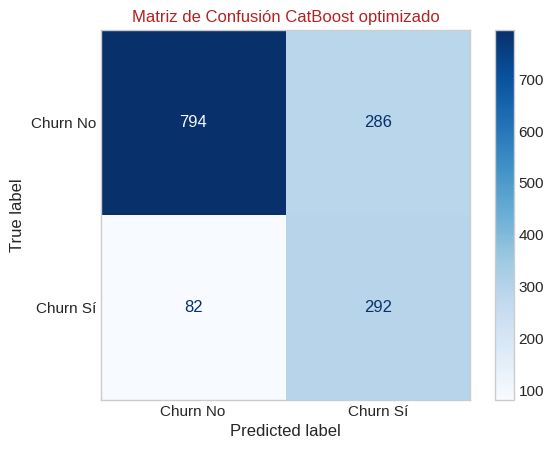

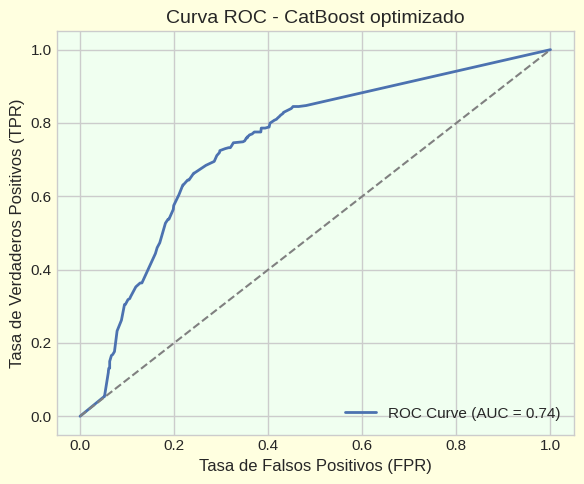

In [67]:
# Mostrar mejores parámetros encontrados
big_print("Mejores parámetros encontrados para CatBoost", 20, 'brown')
print("\n".join([f"{param}: {value}" for param, value in search.best_params_.items()]))

# Evaluar modelo optimizado
mejor_modelo = search.best_estimator_
y_pred = mejor_modelo.predict(X_test)

# Guardar métricas
metricas_modelos.append(calcular_metricas('CatBoost', y_test, y_pred))

# Reporte y visualizaciones
big_print("Reporte de clasificación CatBoost optimizado", 20, 'brown')
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, 'CatBoost optimizado')
plot_roc_curve(pipeline, X_test, y_test, 'CatBoost optimizado')

##Pipeline CatBoost optimizado

In [68]:
# Definimos pipeline con los parámetros calculados previamente
pipeline_cb = search.best_estimator_

# Entrenamos pipeline
pipeline_cb.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# guardamos el pipeline optimizado usando try para manejo de error


ruta_modelo = "pipeline_CatBoost_optimizado.pkl"
joblib.dump(pipeline_cb, ruta_modelo)
big_print(f"Pipeline guardado en {ruta_modelo}",20,'brown')

# cargar el pipeline optimizado
pipeline_cargado = joblib.load(ruta_modelo)
big_print("Pipeline cargado correctamente.",20,'brown')

# ejecutamos el pipeline cargado en test
y_pred_cargado = pipeline_cargado.predict(X_test)

big_print("Reporte de clasificación usando el pipeline cargado:",20,'brown')
print(classification_report(y_test, y_pred_cargado))

              precision    recall  f1-score   support

         0.0       0.91      0.74      0.81      1080
         1.0       0.51      0.78      0.61       374

    accuracy                           0.75      1454
   macro avg       0.71      0.76      0.71      1454
weighted avg       0.80      0.75      0.76      1454



##RandomForestClassifier

##RandomForestClassifier sin optimizaciones

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87      1080
         1.0       0.64      0.46      0.54       374

    accuracy                           0.80      1454
   macro avg       0.74      0.69      0.70      1454
weighted avg       0.78      0.80      0.78      1454



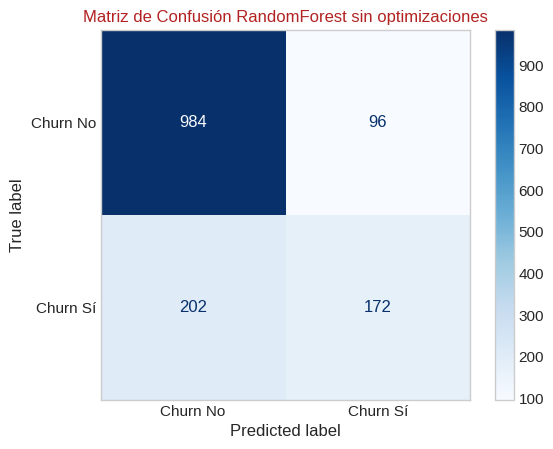

In [69]:
# Cargamos el dataset
df = pd.read_csv('df_codificado.csv')

# Separación de variables dependiente e independientes
X = df.drop('Churn', axis=1)
y = df['Churn']

# Separación en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# creamos modelo RandomForestClassifier
modelo = RandomForestClassifier(random_state=42,max_depth=10)

# entrenamos con conjunto de train
modelo.fit(X_train, y_train)

# revisemos las métricas y la matriz de confusión
y_previsto = modelo.predict(X_test)

big_print("Reporte de Clasificación RandomForest sin optimizaciones", 20,'firebrick')
print(classification_report(y_test, y_previsto))

#mostramos matriz de confusión
plot_confusion_matrix(y_test, y_previsto, 'RandomForest sin optimizaciones')

##RandomForestClassifier con Validación cruzada

Accuracy  : 0.804 ± 0.004
Precision : 0.666 ± 0.011
Recall    : 0.478 ± 0.013
F1        : 0.556 ± 0.011




              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87      1080
         1.0       0.64      0.46      0.54       374

    accuracy                           0.80      1454
   macro avg       0.74      0.69      0.70      1454
weighted avg       0.78      0.80      0.78      1454



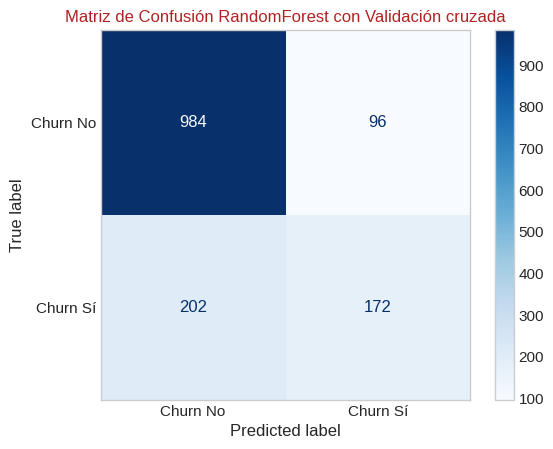

In [70]:
# Cargamos el dataset
df = pd.read_csv('df_codificado.csv')

# Separamos variables predictoras (X) y variable objetivo (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Separamos en conjunto de entrenamiento y prueba (stratify mantiene proporción de clases)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

# Creamos modelo RandomForest
modelo = RandomForestClassifier(random_state=42, max_depth=10)

# Validación cruzada sobre el conjunto de entrenamiento
scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_resultados = cross_validate(modelo, X_train, y_train, cv=5,
                               scoring=scoring, return_train_score=False)

# Mostramos resultados promedios de la validación cruzada
big_print("RandomForest con Validación cruzada",20,'brown')
for metrica in scoring:
    puntajes = cv_resultados[f'test_{metrica}']
    print(f"{metrica.capitalize():<10}: {puntajes.mean():.3f} ± {puntajes.std():.3f}")

# Entrenamos el modelo final con todos los datos de entrenamiento
modelo.fit(X_train, y_train)

# Predecimos con datos de test (jamás vistos por el modelo)
y_pred = modelo.predict(X_test)

# Reporte de clasificación
big_print("Reporte de Clasificación RandomForest con Validación Cruzada", 20,'firebrick')
print(classification_report(y_test, y_pred))

# mostramos matriz de confusión
plot_confusion_matrix(y_test, y_pred, 'RandomForest con Validación cruzada')

##RandomForestClassifier con balanceo de clases

              precision    recall  f1-score   support

         0.0       0.90      0.77      0.83      1080
         1.0       0.54      0.75      0.63       374

    accuracy                           0.77      1454
   macro avg       0.72      0.76      0.73      1454
weighted avg       0.81      0.77      0.78      1454



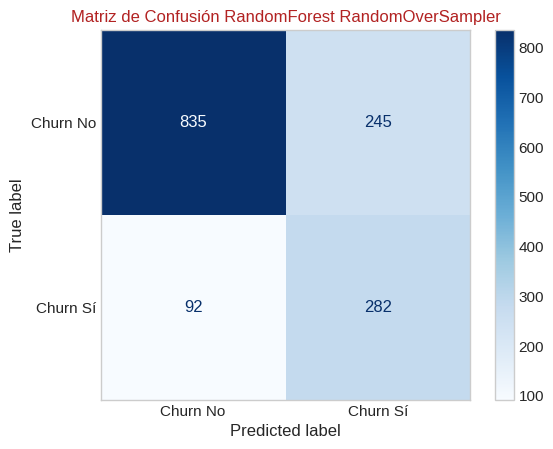

              precision    recall  f1-score   support

         0.0       0.87      0.83      0.85      1080
         1.0       0.57      0.66      0.61       374

    accuracy                           0.78      1454
   macro avg       0.72      0.74      0.73      1454
weighted avg       0.80      0.78      0.79      1454



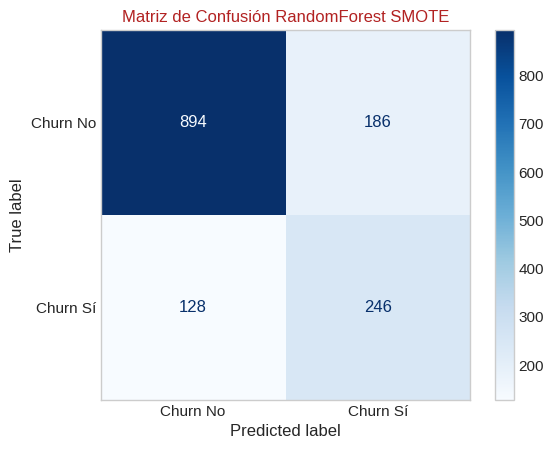

              precision    recall  f1-score   support

         0.0       0.87      0.82      0.85      1080
         1.0       0.56      0.65      0.60       374

    accuracy                           0.78      1454
   macro avg       0.72      0.74      0.72      1454
weighted avg       0.79      0.78      0.78      1454



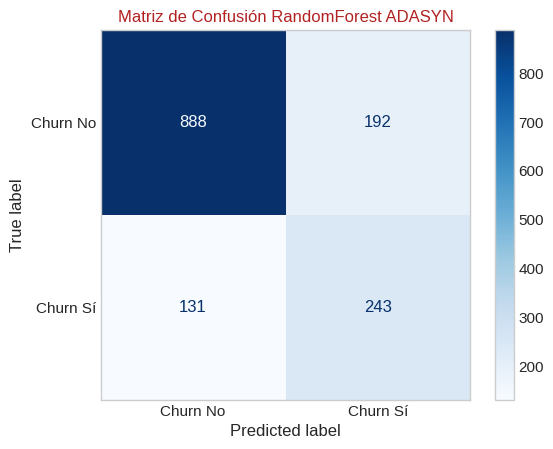

              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86      1080
         1.0       0.60      0.58      0.59       374

    accuracy                           0.79      1454
   macro avg       0.73      0.72      0.72      1454
weighted avg       0.79      0.79      0.79      1454



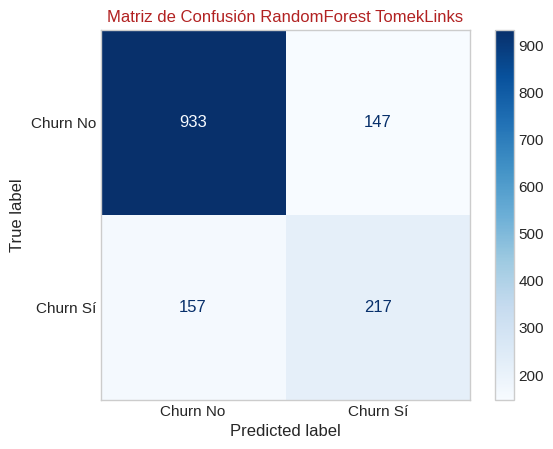

              precision    recall  f1-score   support

         0.0       0.89      0.79      0.84      1080
         1.0       0.54      0.71      0.62       374

    accuracy                           0.77      1454
   macro avg       0.72      0.75      0.73      1454
weighted avg       0.80      0.77      0.78      1454



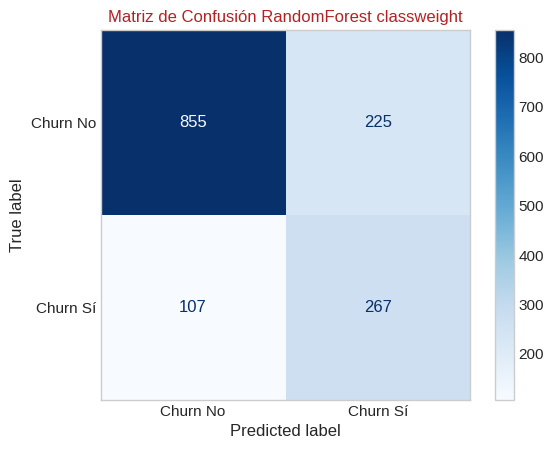

             Técnica  Accuracy  Precision    Recall  F1-score
0  RandomOverSampler  0.768226   0.535104  0.754011  0.625971
4        classweight  0.771664   0.542683  0.713904  0.616628
1              SMOTE  0.784044   0.569444  0.657754  0.610422
2             ADASYN  0.777854   0.558621  0.649733  0.600742
3         TomekLinks  0.790922   0.596154  0.580214  0.588076


In [71]:
# Cargamos datos
df = pd.read_csv("df_codificado.csv")

# Separamos variables
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Separamos en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Diccionario con técnicas de muestreo
samplers = {
    "RandomOverSampler": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "TomekLinks": TomekLinks(),
    "classweight": "balanced"
}

# Almacenar resultados
resultados = []

# Entrenamiento y evaluación por técnica
def entrenar_y_evaluar(X_res, y_res, nombre):
    if nombre == "classweight":
        modelo = RandomForestClassifier(max_depth=10, class_weight='balanced', random_state=42)
    else:
      modelo = RandomForestClassifier(max_depth=10, random_state=42)

    modelo.fit(X_res, y_res)
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    resultados.append({
        "Técnica": nombre,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    })

    big_print(f"===== {nombre} =====",20,'brown')
    print(classification_report(y_test, y_pred))

    # mostramos matriz de confución
    plot_confusion_matrix(y_test, y_pred, f"RandomForest {nombre}")

# Ejecutar para cada técnica
for nombre, sampler in samplers.items():
    try:
        if nombre == "classweight":
          X_res, y_res = (X_train, y_train)
        else:
          X_res, y_res = sampler.fit_resample(X_train, y_train)
        entrenar_y_evaluar(X_res, y_res, nombre)
    except Exception as e:
        print(f"Error en {nombre}: {e}")

# Mostrar tabla comparativa
df_resultados = pd.DataFrame(resultados)
big_print("📊 Métricas RandomForest por Técnica de Balanceo:",20,'brown')
print(df_resultados.sort_values("Recall", ascending=False))


<font color=red size=5>Graficamos Recall y F1 para las cinco técnicas de balanceo</font>

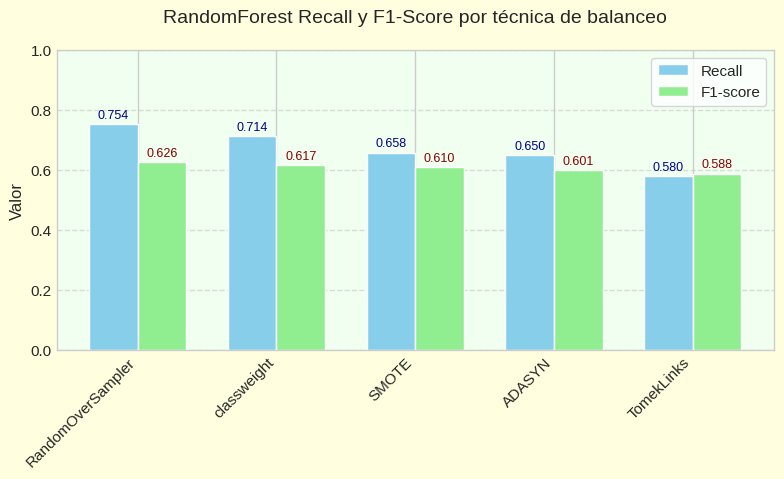

In [72]:
# Ordenar el DataFrame por Recall de mayor a menor
df_sorted = df_resultados.sort_values('Recall', ascending=False)

# Configuración del gráfico
plt.figure(figsize=(8, 4), facecolor='lightyellow')
ax = plt.gca()
ax.set_facecolor('honeydew')

# Configuración de barras
n = len(df_sorted)
bar_width = 0.35
index = np.arange(n)

# Creamos barras para Recall y F1-score
plt.bar(index - bar_width/2, df_sorted['Recall'], bar_width,
        color='skyblue', label='Recall')
plt.bar(index + bar_width/2, df_sorted['F1-score'], bar_width,
        color='lightgreen', label='F1-score')

# Añadimos valores en las barras
for i, (rec, f1) in enumerate(zip(df_sorted['Recall'], df_sorted['F1-score'])):
    plt.text(i - bar_width/2, rec + 0.02, f"{rec:.3f}",
             ha='center', fontsize=9, color='darkblue')
    plt.text(i + bar_width/2, f1 + 0.02, f"{f1:.3f}",
             ha='center', fontsize=9, color='darkred')

# Personalización del gráfico
plt.title('RandomForest Recall y F1-Score por técnica de balanceo', pad=20, fontsize=14)
plt.ylabel('Valor')
plt.ylim(0, 1)
plt.xticks(index, df_sorted['Técnica'], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(frameon=True, loc='best')

# Mejorar espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.15)
# guardamos gráfico como archivo png
plt.savefig('graf_RF_recall_por_tecnica_balaceo.png', dpi=300, bbox_inches='tight')
plt.show()

<font color=red size=5>Intervalo de confianza del Recall</font>

In [73]:
# revisemos el intervalo de confianza para el modelo balanceado con RandomOverSampler
# Cargamos el dataset
df = pd.read_csv('df_codificado.csv')

# Separamos variables predictoras y objetivo
X = df.drop('Churn', axis=1)
y = df['Churn']

# Creamos pipeline con RandomOverSampler + modelo
pipeline = imbpipeline([
    ('oversample', RandomOverSampler(random_state=42)),
    ('modelo', RandomForestClassifier(random_state=42, max_depth=10))
])

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Métrica que quieremos evaluar 'recall'
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='recall')

# Calcular media y desviación estándar
mean_score = np.mean(scores)
std_score = np.std(scores)

# Calcular intervalo de confianza 95%
confidence = 0.95
z = stats.norm.ppf(1 - (1 - confidence)/2)
margin_error = z * std_score / np.sqrt(len(scores))
lower = mean_score - margin_error
upper = mean_score + margin_error

# Mostrar resultados
big_print(f"Recall promedio: {mean_score:.4f}",20,'red')
big_print(f"Intervalo de confianza del 95%: ({lower:.4f}, {upper:.4f})",20,'red')


<font color=red size=5>Curva ROC para RandomForestClassifier</font>

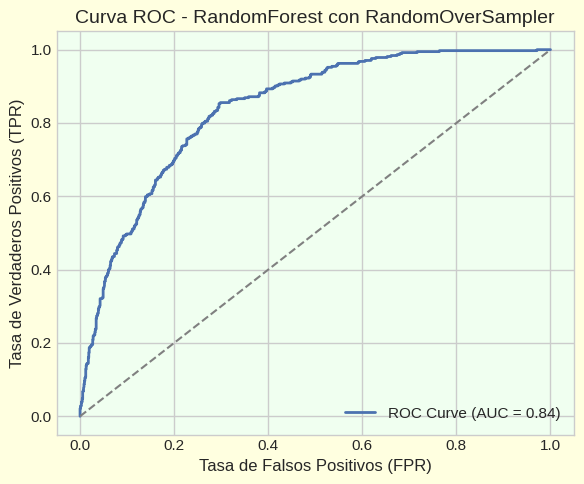

In [74]:
# mostramos curba ROC con el pipeline
titulo = "RandomForest con RandomOverSampler"
plot_roc_curve(pipeline, X_test, y_test,titulo)

##RandomForest  Optimización de parámetros

In [75]:
# Cargar los datos
df = pd.read_csv("df_codificado.csv")
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Separar en Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Pipeline con balanceo y modelo
pipeline = imbpipeline([
    ('oversample', RandomOverSampler(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

# Hiperparámetros a optimizar
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
}

# Scoring personalizado: solo el recall de la clase positiva
recall_pos_scorer = make_scorer(recall_score, pos_label=1)

# Búsqueda aleatoria de parámetros
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    scoring=recall_pos_scorer,  # Enfocado en recall clase 1
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Entrenamiento
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('oversample',
                                              RandomOverSampler(random_state=42)),
                                             ('clf',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'clf__class_weight': ['balanced',
                                                              {0: 1, 1: 2},
                                                              {0: 1, 1: 3}],
                                        'clf__max_depth': [None, 10, 20, 30],
                                        'clf__max_features': ['sqrt', 'log2'],
                                        'clf__min_samples_leaf': [1, 2, 4],
                                        'clf__min_samples_split': [2, 5, 10],
                                        'clf__n_estimators': [100, 200, 300]},
                   random_state=42,
                   scoring=make_scorer(recall_score, response_method='predict', pos_label=1),
                   verbose=2)

clf__n_estimators: 	100
clf__min_samples_split: 	5
clf__min_samples_leaf: 	4
clf__max_features: 	sqrt
clf__max_depth: 	10
clf__class_weight: 	{0: 1, 1: 3}




              precision    recall  f1-score   support

         0.0       0.94      0.62      0.75      1080
         1.0       0.45      0.89      0.59       374

    accuracy                           0.69      1454
   macro avg       0.69      0.75      0.67      1454
weighted avg       0.81      0.69      0.71      1454



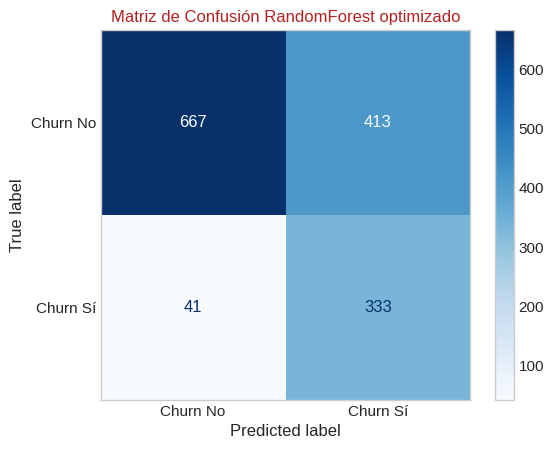

In [76]:
big_print("Mejores parámetros encontrados para RandomForest:",20,'brown')

# imprimimos mejores parámetros
for param, value in random_search.best_params_.items():
    print(f"{param}: \t{value}")

# Evaluar en test
mejor_modelo = random_search.best_estimator_
y_pred = mejor_modelo.predict(X_test)

# guardamos métricas para informe final
metricas_modelos.append(calcular_metricas('RandomForest', y_test, y_pred))

big_print("Reporte de clasificación RandomForest optimizado",20,'brown')
print(classification_report(y_test, y_pred))

# desplegamos matriz de confusión
plot_confusion_matrix(y_test, y_pred, 'RandomForest optimizado')

##Intervalo de confianza de Recall para RandomForest optimizado

In [77]:
# Mejor modelo ya entrenado
mejor_modelo = random_search.best_estimator_

# Número de repeticiones del bootstrap
n_iterations = 1000
recalls = []

# Probabilidades para fijar la semilla y asegurar reproducibilidad
rng = np.random.default_rng(seed=42)

# Bootstrap sobre los datos de test
for _ in range(n_iterations):
    # Re-muestreo con reemplazo
    indices = rng.integers(0, len(X_test), len(X_test))
    X_resampled = X_test.iloc[indices]
    y_resampled = y_test.iloc[indices]

    # Predicción
    y_pred = mejor_modelo.predict(X_resampled)

    # Calcular recall clase 1
    recalls.append(recall_score(y_resampled, y_pred, pos_label=1))

# Intervalo de confianza al 95%
lower = np.percentile(recalls, 2.5)
upper = np.percentile(recalls, 97.5)

big_print(f"Recall medio (clase 1): {np.mean(recalls):.3f}",20,'brown')
big_print(f"IC 95% para Recall clase 1: ({lower:.3f}, {upper:.3f})",20,'brown')


<font color=red size=5>Curva ROC para DecisionTreeClassifier optimizado</font>

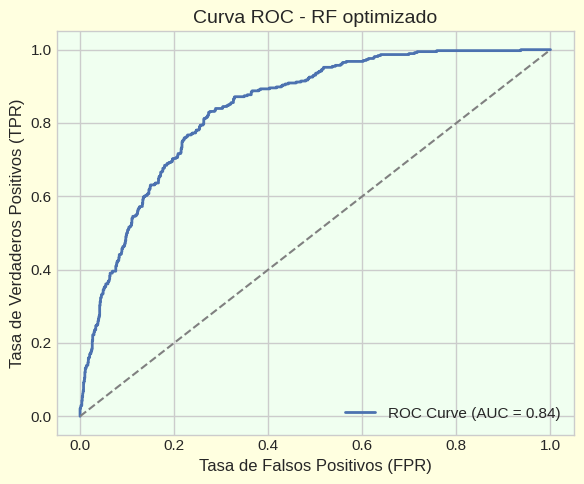

In [78]:
# Mejor modelo optimizado encontrado por RandomizedSearchCV
mejor_modelo = random_search.best_estimator_

# desplegamos curva ROC
titulo = "RF optimizado"
plot_roc_curve(mejor_modelo, X_test, y_test,titulo)

##Pipeline RandomForest optimizado

In [79]:
# Parámetros optimizados que obtuvimos con RandomizedSearchCV

parametros_optimizados = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'bootstrap': True,
    'class_weight': {0: 1, 1: 3},
    'random_state': 42
}

modelo_optimizado = RandomForestClassifier(**parametros_optimizados)
modelo_optimizado.fit(X_train, y_train)

# Creamos el pipeline
pipeline_optimizado = imbpipeline(steps=[
    ('oversample', RandomOverSampler(random_state=42)),
    ('rf', RandomForestClassifier(**parametros_optimizados))
])

# Entrenamos el pipeline en los datos de entrenamiento
pipeline_optimizado.fit(X_train, y_train)

# Evaluamos en el conjunto de prueba
y_pred = pipeline_optimizado.predict(X_test)

# guardamos el pipeline optimizado
ruta_modelo = "pipeline_RandomForest_optimizado.pkl"
joblib.dump(pipeline_optimizado, ruta_modelo)
big_print(f"Pipeline guardado en {ruta_modelo}",20,'brown')

# cargamos pipeline optimizado
pipeline_cargado = joblib.load(ruta_modelo)
big_print("Pipeline cargado correctamente.",20,'brown')

# ejecutamos pipeline sobre test
y_pred_cargado = pipeline_cargado.predict(X_test)

big_print("Reporte de clasificación usando el pipeline cargado:",20,'brown')
print(classification_report(y_test, y_pred_cargado))

              precision    recall  f1-score   support

         0.0       0.94      0.62      0.75      1080
         1.0       0.45      0.89      0.59       374

    accuracy                           0.69      1454
   macro avg       0.69      0.75      0.67      1454
weighted avg       0.81      0.69      0.71      1454



##Feature importance

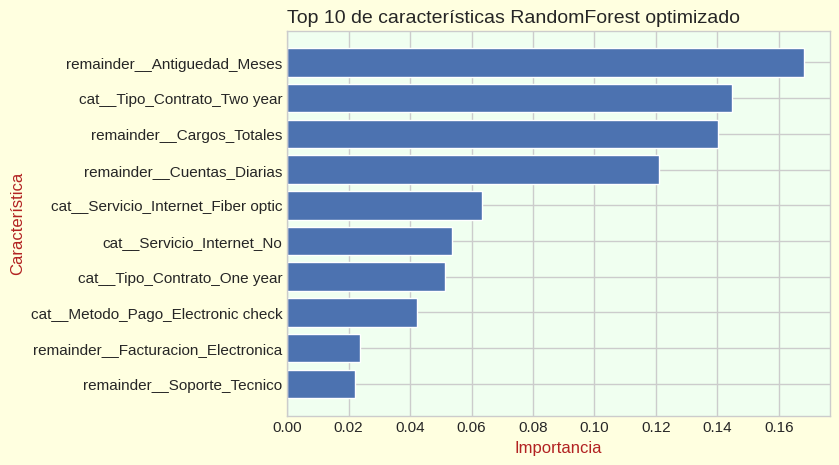

In [80]:
# Accedemos al modelo dentro del pipeline usando su nombre ('rf')
modelo_final = pipeline_optimizado.named_steps['rf']

# Extraemos las importancias del modelo
importancias = modelo_final.feature_importances_

# Creamos un DataFrame para visualización
df_importancias = pd.DataFrame({
    'Característica': X_train.columns,
    'Importancia': importancias
})

# Ordenamos de mayor a menor importancia
df_importancias = df_importancias.sort_values('Importancia', ascending=True)

# seleccionamos solo las características con una importancia mayor al 1%
df_importancias = df_importancias[df_importancias['Importancia'] > 0.02]

# Mostrar las 10 características más importantes
# print(df_importancias.head(10))

# graficamos importancias en barras horizontales en orden descendentes
plt.figure(figsize=(7, 5), facecolor='lightyellow')
ax = plt.gca()
ax.set_facecolor('honeydew')
plt.title('Top 10 de características RandomForest optimizado', fontsize=14, loc='left')
plt.xlabel('Importancia', color='firebrick', fontsize=12)
plt.ylabel('Característica', color='firebrick', fontsize=12)

plt.barh(df_importancias['Característica'], df_importancias['Importancia'])

# guardamos gráfico como archivo png
plt.savefig('graf_RF_importancias.png', dpi=300, bbox_inches='tight')
plt.show()

##Resumen de métricas de modelos

In [81]:
# Crear DataFrame
metricas_df = pd.DataFrame(metricas_modelos)

# Formatear las métricas para mejor visualización
metricas_df_formateado = metricas_df.copy()
for col in ['Accuracy', 'Precision_Clase_1', 'Recall_Clase_1', 'F1-Score_Clase_1']:
    metricas_df_formateado[col] = metricas_df_formateado[col].map('{:.2%}'.format)

# definimos 'Modelo' como index
metricas_df_formateado.set_index('Modelo', inplace=True)
# Mostrar tabla comparativa
big_print("Tabla Comparativa de Modelos:",20,'brown')
display(metricas_df_formateado)

,Accuracy,Precision_Clase_1,Recall_Clase_1,F1-Score_Clase_1
Modelo,,,,
DecisionTree,71.53%,46.83%,78.97%,58.79%
CatBoost,74.69%,50.52%,78.07%,61.34%
RandomForest,68.78%,44.64%,89.04%,59.46%


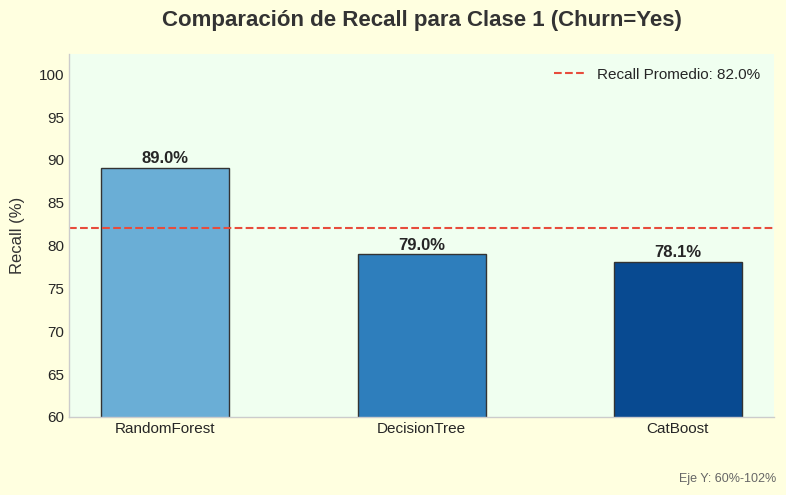

In [82]:
# Ordenar por Recall para mejor visualización
metricas_df = metricas_df.sort_values('Recall_Clase_1', ascending=False)

# Configuración del gráfico
plt.figure(figsize=(8, 5), facecolor='lightyellow')
ax = plt.subplot(facecolor='honeydew')

# Crear colores con gradiente
colors = plt.cm.Blues(np.linspace(0.5, 0.9, len(metricas_df)))

# Crear gráfico de barras
bars = ax.bar(metricas_df['Modelo'],
              metricas_df['Recall_Clase_1'] * 100,
              color=colors,
              edgecolor='#333333',
              width=0.5)

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.,
            height + 0.2,  # Ajuste menor de posición
            f'{height:.1f}%',
            ha='center',
            va='bottom',
            fontsize=12,
            fontweight='bold')

# Personalización
plt.title('Comparación de Recall para Clase 1 (Churn=Yes)',
          fontsize=16, pad=20, fontweight='bold', color='#333333')
plt.xlabel('')
plt.ylabel('Recall (%)', fontsize=12, labelpad=10, color='#333333')

# AJUSTE PRINCIPAL: Eje Y comienza en 60%
y_min = 60
y_max = metricas_df['Recall_Clase_1'].max() * 100 * 1.15  # 15% más de espacio arriba
plt.ylim(y_min, y_max)

# Añadir línea de referencia
avg_recall = metricas_df['Recall_Clase_1'].mean() * 100
plt.axhline(y=avg_recall,
            color='#e74c3c',
            linestyle='--',
            linewidth=1.5,
            label=f'Recall Promedio: {avg_recall:.1f}%')

# Decoración
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#cccccc')
ax.spines['bottom'].set_color('#cccccc')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper right')

# Añadir anotación sobre la escala
plt.figtext(0.98, 0.02,
            f"Eje Y: {y_min}%-{y_max:.0f}%",
            ha='right', fontsize=9, color='#666666')
plt.grid(False)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Más espacio abajo

# guardamos gráfico como archivo png
plt.savefig('graf_recall_por_modelo.png', dpi=300, bbox_inches='tight')
plt.show()

<Axes: xlabel='Antiguedad_Meses', ylabel='Density'>

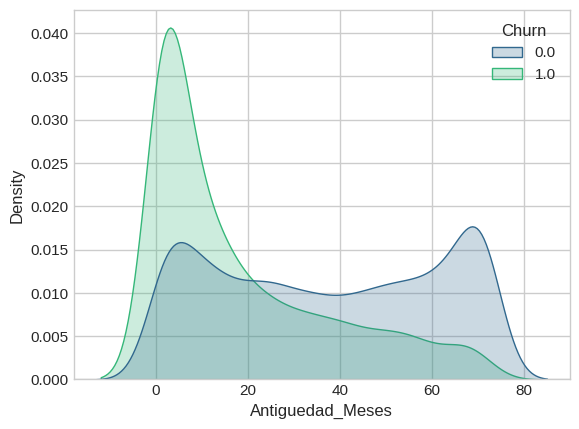

In [97]:
sns.kdeplot(
    data=df,
    x='Antiguedad_Meses',
    hue='Churn',
    common_norm=False,
    fill=True,
    palette='viridis'
)

###Conclusión


El objetivo principal de este proyecto es construir un modelo predictivo capaz de prever qué clientes tienen una alta probabilidad de cancelar sus servicios (Churn), permitiendo a la empresa anticiparse al problema. Este es un problema de clasificación binaria, donde la variable objetivo es 'Churn' (1 si el cliente se va, 0 si no). La métrica clave a priorizar es el Recall (sensibilidad) para la clase positiva (Churn = 1), ya que el objetivo es identificar la mayor cantidad posible de clientes que sí harán churn, minimizando los falsos negativos.
Aquí un resumen de los hallazgos y resultados:

1. **Preparación de Datos y Análisis Exploratorio (EDA)**

• Se utilizó un dataset normalizado de un desafío anterior, donde se eliminaron registros con valores nulos.
• La columna customerID fue eliminada por ser irrelevante para el modelado.
• Se realizó una codificación (encoding) de las variables:
    ◦ Las columnas binarias ('Yes'/'No') se transformaron a 1 y 0 respectivamente.
    ◦ Las columnas categóricas restantes (Genero_Cliente, Servicio_Internet, Tipo_Contrato, Metodo_Pago) se codificaron utilizando OneHotEncoder.
• Se observó una fuerte correlación entre Charges.Monthly y Charges.Total, por lo que Charges.Monthly fue eliminada para simplificar el dataset.
• El análisis de correlación se centró en las variables con una correlación superior al 15% con 'Churn'.
• El análisis de multicolinealidad fue omitido porque los modelos a probar no son sensibles a ella.
2. **Hallazgos del Análisis Exploratorio de Datos (EDA)**

• Proporción de Churn: El dataset muestra un desequilibrio de clases; la distribución de Churn (Sí/No) se analiza mediante un gráfico de torta.
• Churn por Antigüedad (Tenure): Se identificó que la mayor deserción (Churn=Yes) ocurre en los primeros 12 meses de permanencia, particularmente en los meses de 0 a 6.
• Categorías con Mayor Porcentaje de Churn: Se analizaron las características categóricas para identificar cuáles tienen el mayor porcentaje de Churn. Esto incluyó Genero_Cliente, Cliente_TerceraEdad, Servicio_Internet, Tipo_Contrato, Metodo_Pago, entre otras. Un gráfico de barras horizontales muestra el Top 10 de categorías con mayor porcentaje de Churn, comparándolas con el churn promedio.
3. **Modelos Probados y sus Resultados**

Se probaron tres modelos de clasificación:
DecisionTreeClassifier, RandomForestClassifier y CatBoost. El objetivo fue optimizar el recall para la clase 1 (Churn Sí).

• **DecisionTreeClassifier (DTC)**:
    ◦ Sin optimizaciones: Obtuvo un Recall de solo el 48% para la clase Churn Sí, lo que lo hace "prácticamente inútil" para el objetivo de identificar clientes propensos a la cancelación.
    ◦ Con Validación Cruzada: Las métricas fueron similares (Recall 49%) a las del modelo sin optimizaciones, sugiriendo estabilidad y buena generalización del modelo, pero sin mejora en el recall.
    ◦ Con Balanceo de Clases: Se probaron RandomOverSampler, SMOTE, ADASYN y TomekLinks. RandomOverSampler fue la técnica que proporcionó el mejor Recall para Churn Sí, a pesar de una precisión más baja, y también el mejor F1-score en términos globales. El recall promedio con RandomOverSampler fue de 0.8122, con un intervalo de confianza del 95% de (0.7818, 0.8426).
    ◦ Con Optimización de Parámetros (utilizando RandomOverSampler y GridSearchCV): Se buscaron los mejores hiperparámetros (max_depth, min_samples_split, min_samples_leaf, criterion) priorizando el recall_score para la clase 1. Los resultados de clasificación y la matriz de confusión mejoraron, y el pipeline optimizado fue guardado.

•  CatBoost:
    ◦ Sin optimizaciones: Similar a DTC, el modelo tuvo un bajo Recall para Churn Sí (alrededor del 48-49% en patrones observados).
    ◦ Con Validación Cruzada: Se observaron métricas estables pero no significativamente mejores.
    ◦ Con Balanceo de Clases: Se comparó auto_class_weights='Balanced' con un class_weights calculado (n_class0 / n_class1). El balanceo utilizando weight_ratio = n_class0 / n_class1 mostró resultados "mucho mejores" que el balanceo automático.
    ◦ Con Optimización de Parámetros (utilizando RandomizedSearchCV): Se optimizaron parámetros como depth, learning_rate, l2_leaf_reg, border_count, min_data_in_leaf y grow_policy, priorizando el recall. El modelo optimizado y su pipeline fueron guardados.

• **RandomForestClassifier (RFC)**:
    ◦ Sin optimizaciones: Al igual que los otros modelos sin ajustes, mostró un Recall de solo el 48% para la clase Churn Sí, lo que lo hace poco útil para el objetivo principal.
    ◦ Con Validación Cruzada: Las métricas se mantuvieron similares (Recall 48%), confirmando la estabilidad del modelo.
    ◦ Con Balanceo de Clases: Se probaron las mismas cuatro técnicas de muestreo que con DTC, además de la opción propia de class_weight='balanced'. RandomOverSampler nuevamente demostró ser la técnica con el mejor Recall. El recall promedio para este modelo con RandomOverSampler fue de 0.8122, con un intervalo de confianza del 95% de (0.7818, 0.8426).
    ◦ Con Optimización de Parámetros (utilizando RandomOverSampler y RandomizedSearchCV): Se optimizaron hiperparámetros como n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, y class_weight ({0: 1, 1: 3} fue el mejor), enfocándose en el recall_pos_scorer. El RandomForestClassifier optimizado predijo correctamente al 90% de los Churn Sí y al 61% de los Churn No, siendo considerado un modelo aceptable. El recall medio para la clase 1 fue de 0.898, con un IC 95% de (0.871, 0.923). El pipeline optimizado fue guardado.
    ◦ Importancia de las Variables (Feature Importance): Se identificaron las características más importantes para el modelo RandomForest optimizado, aquellas con una importancia superior al 2%.

4. **Resumen y Comparación Final de Modelos Optimizados**

• Se creó una tabla comparativa y un gráfico de barras para visualizar el Accuracy, Precision_Clase_1, Recall_Clase_1 y F1-Score_Clase_1 de los modelos DecisionTree, CatBoost y RandomForest, todos en sus versiones optimizadas.
• El gráfico de comparación de Recall para la Clase 1 (Churn=Yes) muestra claramente el rendimiento de cada modelo respecto al objetivo clave.
En resumen, los resultados del código muestran un proceso exhaustivo de modelado para la predicción de churn, priorizando la capacidad de los modelos para identificar correctamente a los clientes que abandonarán el servicio. Los modelos optimizados, especialmente RandomForestClassifier, lograron un Recall muy alto (90%) para la clase Churn Sí, lo que cumple con el objetivo principal de este proyecto.